# Importando Bibliotecas

In [1]:
# Importando as bibliotecas necessárias
import os
import pandas as pd
import random
import dill
import glob
import numpy as np
import torch
# Visualizando a distribuição dos valores pagos em sinistros
import matplotlib.pyplot as plt
import seaborn as sns


from darts.dataprocessing.transformers import MissingValuesFiller
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import GaussianLikelihood
from pytorch_lightning.callbacks import EarlyStopping
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_contour
from darts.metrics import mse,rmse,rmsle,mae,mape,smape,qr,ql,ope
from darts.models import RNNModel
from optuna.visualization import (
    plot_param_importances,
    plot_parallel_coordinate,
    plot_optimization_history,
    plot_contour
)
import plotly.io as pio
# pio.renderers.default = 'colab'





# Reutiliza o dataset pré-tratado

Carrega o dataset final pré-processado (gerado pelo notebook `treatment.ipynb`) para alimentar a pipeline de previsão.

**Contexto do Fluxo:**  
1. **Origem dos dados**:  
   - Pré-processados em `treatment.ipynb` (limpeza, feature engineering)  
   - Salvos em `../data/processed/trated_data.csv`  

In [2]:
# Salva o DataFrame final_merged_data como CSV
paste = '../'
paste_graph = '../reports/figures'
file_path = '../data/processed/trated_data.csv'
df = pd.read_csv(file_path, sep=';')
df

D_OCORR   INDENIZ  EVENTO_1  EVENTO_2  EVENTO_3  EVENTO_4  EVENTO_5  \
0     1970-01-01    6477.0       0.0       1.0       0.0       0.0       0.0   
1     1981-03-05    3742.0       0.0       1.0       0.0       0.0       0.0   
2     1988-11-19  187500.0       1.0       0.0       0.0       0.0       0.0   
3     1992-01-19    1400.0       1.0       0.0       0.0       0.0       0.0   
4     1993-08-11   80413.0       1.0       0.0       0.0       0.0       0.0   
...          ...       ...       ...       ...       ...       ...       ...   
3769  2020-09-05    2522.0       0.0       1.0       0.0       0.0       0.0   
3770  2020-09-08    3000.0       0.0       1.0       0.0       0.0       0.0   
3771  2020-10-08    3593.0       0.0       1.0       0.0       0.0       0.0   
3772  2020-11-27    2876.0       0.0       1.0       0.0       0.0       0.0   
3773  2021-01-13    9696.0       0.0       1.0       0.0       0.0       0.0   

      EVENTO_6  EVENTO_7  EVENTO_8  ...  REGIAO_42.0  REGIAO_43.0  \
0          0.0       0.0       0.0  ...          0.0          0.0   
1          0.0       0.0       0.0  ...          0.0          0.0   
2          0.0       0.0       0.0  ...          0.0          0.0   
3          0.0       0.0       0.0  ...          0.0          0.0   
4          0.0       0.0       0.0  ...          0.0          0.0   
...        ...       ...       ...  ...          ...          ...   
3769       0.0       0.0       0.0  ...          0.0          0.0   
3770       0.0       0.0       0.0  ...          0.0          0.0   
3771       0.0       0.0       0.0  ...          0.0          0.0   
3772       0.0       0.0       0.0  ...          0.0          0.0   
3773       0.0       0.0       0.0  ...          0.0          0.0   

      REGIAO_50.0  REGIAO_51.0  REGIAO_52.0  REGIAO_53.0  SEXO_F  SEXO_M  \
0             0.0          0.0          0.0          0.0     0.0     1.0   
1             0.0          0.0          0.0          0.0     1.0     0.0   
2             0.0          0.0          0.0          0.0     0.0     1.0   
3             0.0          0.0          0.0          0.0     0.0     1.0   
4             0.0          0.0          0.0          0.0     0.0     1.0   
...           ...          ...          ...          ...     ...     ...   
3769          1.0          0.0          0.0          0.0     1.0     0.0   
3770          0.0          0.0          0.0          0.0     0.0     1.0   
3771          0.0          0.0          0.0          0.0     0.0     1.0   
3772          0.0          0.0          0.0          0.0     0.0     1.0   
3773          0.0          0.0          0.0          0.0     0.0     1.0   

      VAL_SALVAD  VAL_RESS  
0            0.0       0.0  
1            0.0       0.0  
2            0.0       0.0  
3            0.0       0.0  
4            0.0       0.0  
...          ...       ...  
3769         0.0       0.0  
3770         0.0       0.0  
3771         0.0       0.0  
3772         0.0       0.0  
3773         0.0       0.0  

[3774 rows x 53 columns]

# Cria uma série Darts

Transforma os dados de indenizações em uma série temporal diária e gera um gráfico de análise para o período 2015-2019.

**Processo em 3 etapas:**  

1. **Conversão para Série Temporal**  
   - Transforma o DataFrame em objeto `TimeSeries` usando:  
     - `D_OCORR` como coluna temporal  
     - Frequência diária (`freq='D'`)  
     - Preenchimento automático de datas faltantes  

2. **Filtro do Período**  
   - Seleciona apenas dados entre:  
     - 01/01/2015 (início)  
     - 31/12/2019 (fim)  

3. **Visualização**  
   - Gera gráfico de linha com:  
     - Estilo personalizado (cor preta, transparência 0.8)  
     - Eixos com fonte em negrito  
     - Legendas claras  
   - Exporta em dois formatos:  
     - PDF (para relatórios)  
     - PNG (para incorporação)  

**Saída:**  
Gráfico de Indenizações 2015-2019: (.../reports/figures/indenizacao_2015_2019.png)  


**Descrição das Colunas:**

1. **D_OCORR** (Data da Ocorrência): Data em que ocorreu o sinistro, usada para organizar e agrupar os registros no tempo.
   
2. **INDENIZ** (Valor da Indenização): Valor pago pela seguradora para cobrir o sinistro. Essa é a variável-alvo do modelo, ou seja, o que queremos prever.

3. **MODALIDADE**: Tipo de modalidade de seguro contratada. Representada por várias subcategorias após o One-Hot Encoding.

4. **TIPO_PROD**: Tipo de produto de seguro. Representado por subcategorias após o One-Hot Encoding.

5. **SEXO**: Gênero do segurado (Masculino ou Feminino). Representado por subcategorias (SEXO_F e SEXO_M) após o One-Hot Encoding.

6. **REGIAO**: Região geográfica onde o segurado está localizado. Representado por subcategorias após o One-Hot Encoding com base nos códigos oficiais dos estados brasileiros.

7. **VAL_SALVAD** (Valor Salvado): Valor residual recuperado após o sinistro, geralmente relacionado ao que restou do veículo. Usado como uma variável contínua nas previsões.

8. **VAL_RESS** (Valor Residual): Valor residual relacionado à apólice, referente a deduções aplicadas após o sinistro. Também usada como uma variável contínua.

9. **EVENTO** Refere-se ao tipo de evento relacionado ao sinistro, podendo variar entre diferentes causas, como roubo, colisão, incêndio, etc. A codificação varia de 1 a 9, representando diferentes tipos de eventos.

10. **CAUSA**: Indica a causa específica do sinistro, com códigos que variam de 1 a 8. Cada código representa uma causa distinta, como falha mecânica, erro do motorista, causas naturais, entre outras.

**Covariáveis:**

- **Covariáveis Passadas**: Todas as variáveis categóricas e contínuas, exceto a coluna de data (`D_OCORR`) e o alvo (`INDENIZ`). Essas covariáveis incluem:
   - **MODALIDADE** (subcategorias)
   - **TIPO_PROD** (subcategorias)
   - **SEXO** (subcategorias)
   - **REGIAO** (subcategorias)
   - **VAL_SALVAD** e **VAL_RESS** (variáveis contínuas)

- **Covariáveis Futuras**: O atributo **D_OCORR** será usado para capturar padrões temporais ao longo do tempo.

**Variável-Alvo:**
**INDENIZ** (Valor da Indenização): O valor a ser previsto com base nas covariáveis categóricas e contínuas fornecidas.



In [3]:
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller

# Cria a série TimeSeries
df_series = TimeSeries.from_dataframe(
    df,
    # value_cols='INDENIZ',  # Coluna alvo
    time_col='D_OCORR',
    fill_missing_dates=True,  # Preenche datas ausentes
    freq='D'  # Frequência diária
)


# Preenche valores faltantes
df_series = MissingValuesFiller().transform(df_series)

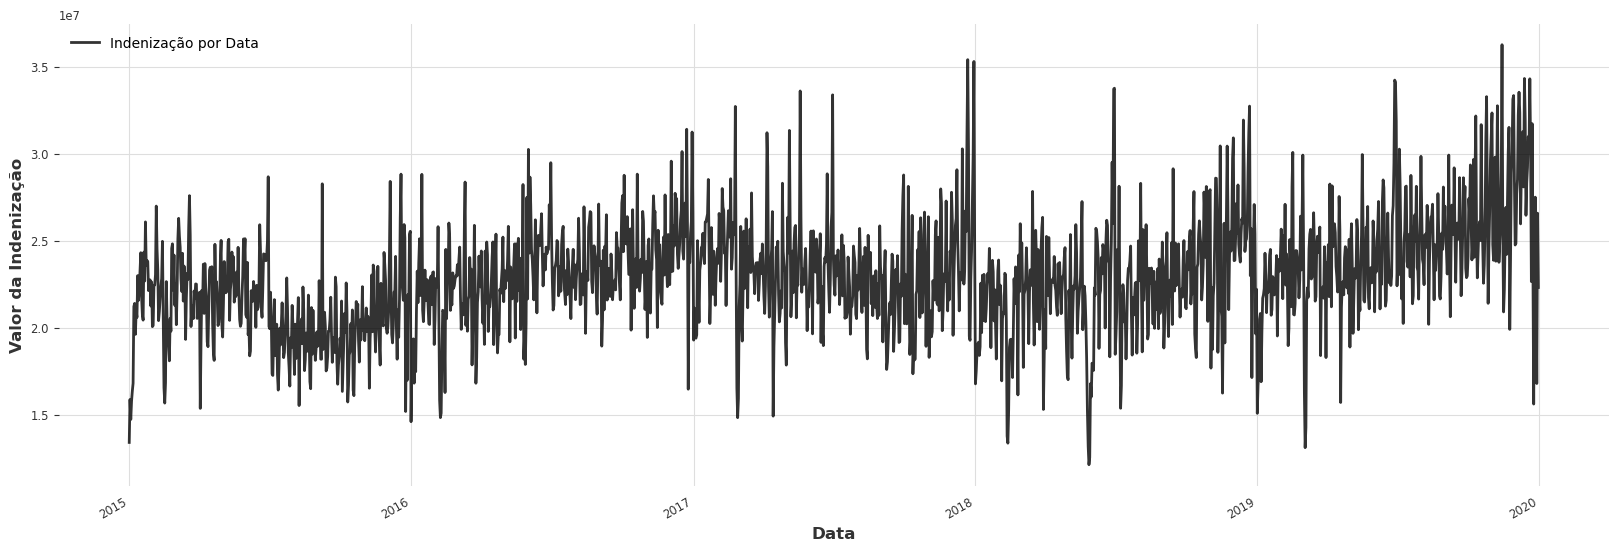

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtra a série para os anos de 2015 a 2019 usando o método slice
filtered_series = df_series.slice(pd.Timestamp('2015-01-01'), pd.Timestamp('2019-12-31'))

# Plota a indenização nesse período
plt.figure(figsize=(20, 6))
filtered_series['INDENIZ'].plot(label='Indenização por Data',color='black',alpha = 0.8)

# Adiciona título e rótulos
# plt.title('Indenização por Data (2015-2019)', fontsize=14)
plt.xlabel('Data', fontsize=12, fontweight='bold')
plt.ylabel('Valor da Indenização', fontsize=12, fontweight='bold')

# Exibe a legenda
plt.legend()

# Salva o gráfico em PDF
plt.savefig(os.path.join(paste_graph,'indenizacao_2015_2019.pdf'))
plt.savefig(os.path.join(paste_graph,'indenizacao_2015_2019.png'))

# Exibe o gráfico
plt.show()


# Divisão do Dataset

Divide os dados temporais em conjuntos estruturados para treinamento, validação, calibração e teste do modelo de previsão.

**Estratégia de divisão:**  
1. **Divisão Primária (85%/15%)**  
   - 85% dados iniciais: treino + validação  
   - 15% dados finais: teste + calibração  

2. **Subdivisão do Treino (70%/30%)**  
   - 70% do conjunto principal: treino real  
   - 30% do conjunto principal: validação  

3. **Divisão do Teste (50%/50%)**  
   - Metade para calibração do modelo  
   - Metade para teste final  

**Saídas Confirmadas:**  
```python
# Tamanhos dos conjuntos
print(f"Dias de Treino: {train_series.n_timesteps}")
print(f"Dias de Validação: {val_series.n_timesteps}")
print(f"Dias de Calibração: {cal_series.n_timesteps}") 
print(f"Dias de Teste Final: {test_final_series.n_timesteps}")

In [5]:
df_series = filtered_series

# Define as proporções de divisão dos dados
train_val_size = int(0.85 * len(df_series))  # 85% para treino_geral (treino + validação)
test_size = len(df_series) - train_val_size  # 15% para teste (que será dividido em calibração e teste)

# 1. Divide em treino_geral (treino + validação) e teste (que será usado depois para calibração e teste final)
treino_geral_series, test_series = df_series.split_after(train_val_size)

# 2. Divide treino_geral em treino e validação
train_size = int(0.7 * len(treino_geral_series))  # 70% do treino_geral para treino real
train_series, val_series = treino_geral_series.split_after(train_size)

# Define a proporção para calibração e teste final
cal_size = int(0.5 * len(test_series))  # 50% para calibração e 50% para teste final

# 3. Divide test_series em calibração e teste final
cal_series, test_final_series = test_series.split_after(cal_size)

# Exibe as dimensões das séries divididas
print(f"Treino Series - Timesteps: {train_series.n_timesteps}, Components: {train_series.n_components}")
print(f"Validação Series - Timesteps: {val_series.n_timesteps}, Components: {val_series.n_components}")
print(f"Calibração Series - Timesteps: {cal_series.n_timesteps}, Components: {cal_series.n_components}")
print(f"Teste Final Series - Timesteps: {test_final_series.n_timesteps}, Components: {test_final_series.n_components}")



Treino Series - Timesteps: 1088, Components: 52
Validação Series - Timesteps: 465, Components: 52
Calibração Series - Timesteps: 137, Components: 52
Teste Final Series - Timesteps: 136, Components: 52


## Covariáveis Futuras

Cria variáveis auxiliares temporais (covariáveis futuras) para enriquecer o modelo de previsão com informações do dia da semana.

**Detalhes técnicos:**  

1. **Geração de covariáveis**:  
   - Extrai o **dia da semana** (1=Segunda a 7=Domingo) das datas de treino/validação  
   - Codifica em **one-hot encoding** (7 dimensões por dia)  
   - Tipo de dados: float32 (otimizado para modelos de ML)  

2. **Aplicação**:  
   - `train_future_covariates`: Para conjunto de treino  
   - `val_future_covariates`: Para conjunto de validação  

3. **Verificação**:  
   - Mostra dimensões geradas (timesteps × componentes)  
   - Exemplo: 7 componentes = [Seg, Ter, Qua, Qui, Sex, Sáb, Dom]  

**Por que é importante?**  
- Captura padrões semanais (ex: indenizações maiores em finais de semana)  
- Melhora a precisão do modelo temporal  

In [6]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Cria as covariáveis futuras (day_series) para o treino e validação a partir de 'D_OCORR'
train_future_covariates = datetime_attribute_timeseries(
    train_series.time_index,
    attribute="day",  # Aqui estamos pegando a informação do "dia"
    one_hot=True,
    dtype=np.float32
)

val_future_covariates = datetime_attribute_timeseries(
    val_series.time_index,
    attribute="day",
    one_hot=True,
    dtype=np.float32
)

# Exibe as dimensões das covariáveis futuras
print(f"Train Future Covariates - Timesteps: {train_future_covariates.n_timesteps}, Components: {train_future_covariates.n_components}")
print(f"Validation Future Covariates - Timesteps: {val_future_covariates.n_timesteps}, Components: {val_future_covariates.n_components}")


Train Future Covariates - Timesteps: 1088, Components: 31
Validation Future Covariates - Timesteps: 465, Components: 31


# Normalizando os dados de treinamento


Normaliza as variáveis numéricas contínuas para o modelo de previsão temporal e gera visualização dos dados normalizados.

**Processo executado:**

1. **Seleção e Normalização:**
   - Variáveis normalizadas: `INDENIZ`, `VAL_SALVAD`, `VAL_RESS`
   - Aplicação do `Scaler` (padronização z-score):
     - Treinado apenas nos dados de treino (`fit_transform`)
     - Aplicado consistentemente aos demais conjuntos (`transform`)

2. **Controle de Qualidade:**
   - Verificação das dimensões pós-normalização
   - Garantia de que todos os conjuntos têm mesma escala

3. **Visualização:**
   - Gráfico temporal da série `INDENIZ` normalizada
   - Eixos com rótulos descritivos
   - Visualização apenas do conjunto de treino

**Saídas Geradas:**
- Séries temporais normalizadas (train/val/cal/test)
- Gráfico de linha da variável-alvo normalizada

In [7]:
from darts.dataprocessing.transformers import Scaler

# Seleciona as colunas contínuas que precisam de normalização
continuous_columns = ['INDENIZ', 'VAL_SALVAD', 'VAL_RESS']

# Cria um scaler para as variáveis contínuas
scaler = Scaler()

# Aplica o scaler nas colunas contínuas da série de treino
train_continuous_scaled = scaler.fit_transform(train_series[continuous_columns])

# Aplica o scaler treinado nos dados de validação, calibração e teste
val_continuous_scaled = scaler.transform(val_series[continuous_columns])
cal_continuous_scaled = scaler.transform(cal_series[continuous_columns])
test_continuous_scaled = scaler.transform(test_final_series[continuous_columns])

# Exibe as dimensões após a normalização
print(f"Train Series (Scaled) - Timesteps: {train_continuous_scaled.n_timesteps}, Components: {train_continuous_scaled.n_components}")
print(f"Validation Series (Scaled) - Timesteps: {val_continuous_scaled.n_timesteps}, Components: {val_continuous_scaled.n_components}")
print(f"Calibration Series (Scaled) - Timesteps: {cal_continuous_scaled.n_timesteps}, Components: {cal_continuous_scaled.n_components}")
print(f"Test Final Series (Scaled) - Timesteps: {test_continuous_scaled.n_timesteps}, Components: {test_continuous_scaled.n_components}")


Train Series (Scaled) - Timesteps: 1088, Components: 3
Validation Series (Scaled) - Timesteps: 465, Components: 3
Calibration Series (Scaled) - Timesteps: 137, Components: 3
Test Final Series (Scaled) - Timesteps: 136, Components: 3


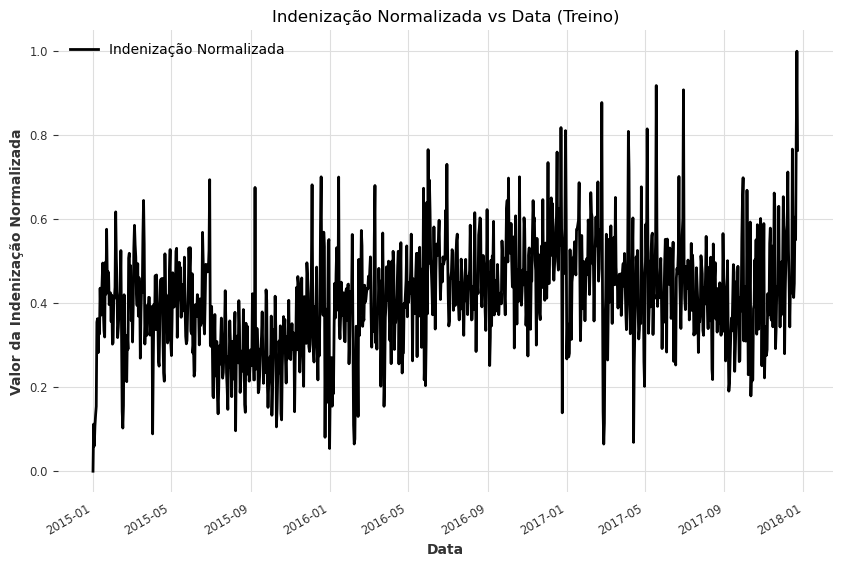

In [8]:
# Seleciona a série normalizada da indenização
train_indenizacao_scaled = train_continuous_scaled['INDENIZ']

# Plota a indenização normalizada no treino
plt.figure(figsize=(10, 6))
train_indenizacao_scaled.plot(label='Indenização Normalizada')

# Adiciona título e rótulos
plt.title('Indenização Normalizada vs Data (Treino)')
plt.xlabel('Data')
plt.ylabel('Valor da Indenização Normalizada')

# Exibe o gráfico
plt.show()


# Análise da Otimização Optuna

**O que esta célula faz:**  
Analisa e visualiza os resultados da otimização de hiperparâmetros realizada com Optuna.

**Processo detalhado:**

1. **Carregamento dos Resultados**:
   - Recupera o estudo salvo anteriormente (`optuna_study.pkl`)
   - Extrai os melhores hiperparâmetros encontrados

2. **Geração de Visualizações**:
   - **Importância dos Parâmetros**: Mostra quais parâmetros mais impactaram no desempenho
   - **Gráfico de Contorno**: Relação entre pares de hiperparâmetros
   - **Coordenadas Paralelas**: Interações entre múltiplos parâmetros
   - **Histórico de Otimização**: Evolução do desempenho ao longo das tentativas

3. **Customização e Exportação**:
   - Aplica layout padronizado (cores de fundo e margens)
   - Salva cada visualização como arquivo HTML interativo
   - Mantém compatibilidade com exportação PNG (comentada)

**Arquivos Gerados**:
- `param_importances.html`
- `contour_plot.html` 
- `parallel_coordinate.html`
- `optimization_history.html`

**Configurações Técnicas**:
- Biblioteca de visualização: Plotly
- Formato de saída: HTML (para interatividade)
- Diretório de saída: `../reports/figures/`

In [9]:
path_study = '../models/optuna_study.pkl'
# Carrega o study salvo usando dill
with open(path_study, 'rb') as f:
    loaded_study = dill.load(f)

# Acessa os melhores hiperparâmetros
print(f"Melhores Hiperparâmetros: {loaded_study.best_trial.params}")


Melhores Hiperparâmetros: {'hidden_dim': 53, 'n_rnn_layers': 1, 'dropout': 0.19167233482343032, 'batch_size': 62}


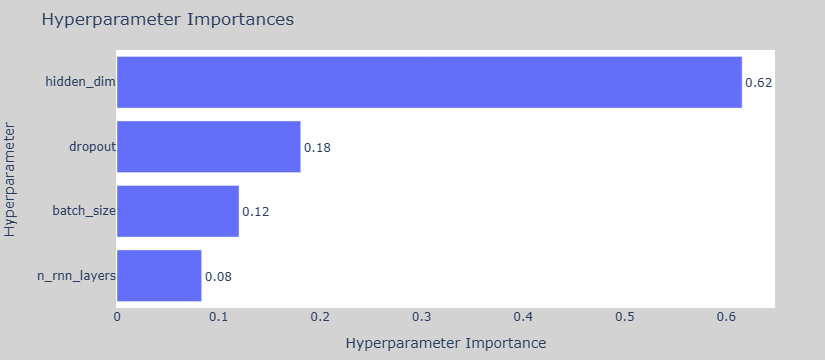

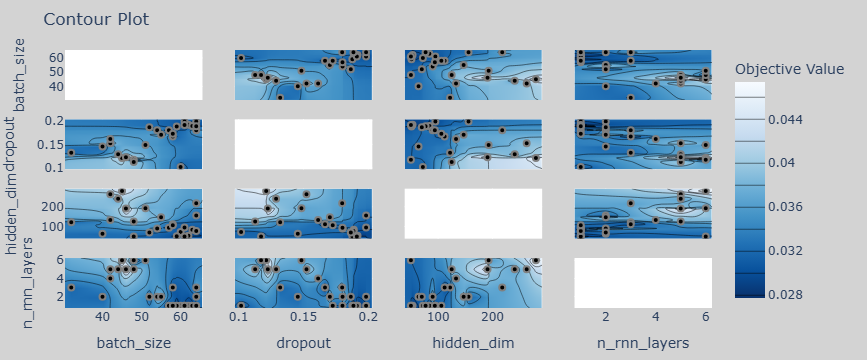

In [12]:
from optuna.visualization import (
    plot_param_importances,
    plot_parallel_coordinate,
    plot_optimization_history,
    plot_contour
)
import plotly.io as pio
import os

# Define caminho para salvar os arquivos PDF
save_path = paste_graph

# Função para ajustar o layout com o fundo e margens
def adjust_plot_layout(fig):
    fig.update_layout(
        plot_bgcolor='white',  # Cor do fundo dentro do gráfico
        paper_bgcolor='lightgrey',  # Cor do fundo da área ao redor do gráfico
        margin=dict(l=50, r=50, t=50, b=50)  # Ajusta as margens
    )
    return fig

# Plota a importância dos parâmetros e salvar como PNG
fig_importance = plot_param_importances(loaded_study)
fig_importance = adjust_plot_layout(fig_importance)
fig_importance.show()
# pio.write_image(fig_importance, os.path.join(save_path, 'param_importances.png'), format='png')
pio.write_html(fig_importance, os.path.join(save_path, 'param_importances.html'))

# Plota o gráfico de contorno e salvar como PNG
fig_contour = plot_contour(loaded_study)
fig_contour = adjust_plot_layout(fig_contour)
fig_contour.show()
# pio.write_image(fig_contour, os.path.join(save_path, 'contour_plot.png'), format='png')
pio.write_html(fig_contour, os.path.join(save_path, 'contour_plot.html'))


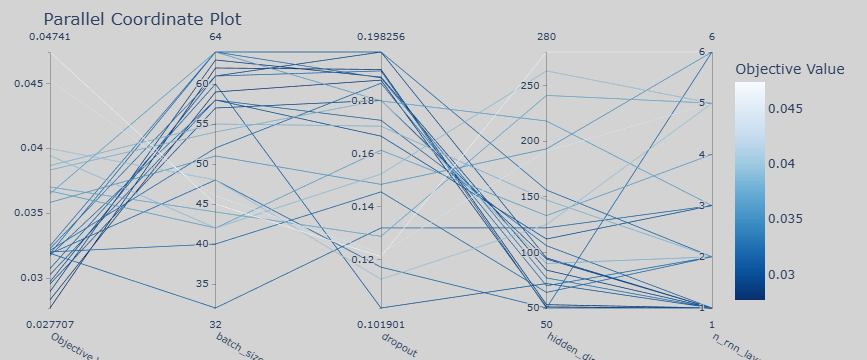

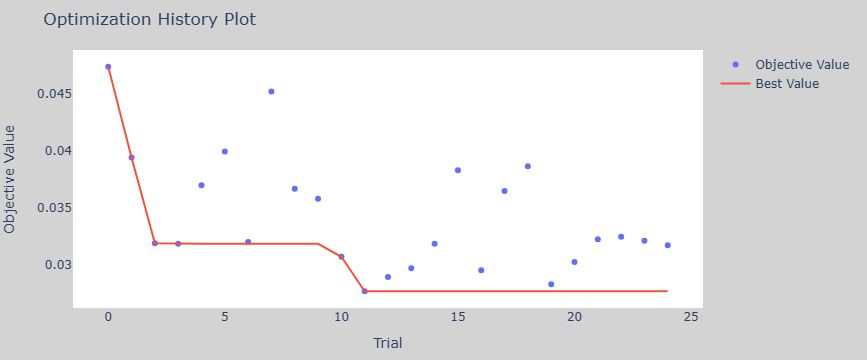

In [13]:
# Plota o gráfico de coordenadas paralelas e salvar como PNG
fig_parallel = plot_parallel_coordinate(loaded_study)
fig_parallel = adjust_plot_layout(fig_parallel)
fig_parallel.show()
# pio.write_image(fig_parallel, os.path.join(save_path, 'parallel_coordinate.png'), format='png')
pio.write_html(fig_parallel, os.path.join(save_path, 'parallel_coordinate.html'))

# Plota o histórico de otimização e salvar como PNG
fig_history = plot_optimization_history(loaded_study)
fig_history = adjust_plot_layout(fig_history)
fig_history.show()
# pio.write_image(fig_history, os.path.join(save_path, 'optimization_history.png'), format='png')
pio.write_html(fig_history, os.path.join(save_path, 'optimization_history.html'))

# Aplicação do Modelo - Pós Otimização

**O que esta célula faz:**  
Executa o pipeline completo de previsão temporal com o modelo LSTM otimizado e avalia seu desempenho.

**Fluxo principal:**

1. **Pré-processamento**  
   - Normalização univariada da variável-alvo `INDENIZ`  
   - Geração de covariáveis futuras (dia da semana em one-hot encoding)

2. **Carga do Modelo**  
   - Recupera o modelo LSTM treinado salvo em `../models/best_lstm_model.pt`  
   - Compatível com CPU (fallback seguro)

3. **Geração de Previsões**  
   - Produz 50 amostras probabilísticas para o período de validação  
   - Inclui intervalo de confiança (5%-95%)

4. **Avaliação Quantitativa**  
   - Calcula 12 métricas de desempenho:  
     - Erros absolutos (MAE, RMSE)  
     - Erros percentuais (MAPE, SMAPE)  
     - Métricas quantílicas (QL, QR para 25%, 50%, 75%)

5. **Visualização e Exportação**  
   - Gráfico comparativo (valores reais vs previstos)  
   - Salva em PNG e PDF  
   - Tabela resumo das métricas

**Saídas Destacadas:**  
- Gráfico interativo com previsões e incerteza  
- Dataframe `metrics_val` com desempenho detalhado  
- Arquivos de imagem em `../reports/figures/`

## Validação

In [14]:
from darts.dataprocessing.transformers import Scaler

# Seleciona apenas a coluna 'INDENIZ' das séries de treino, validação, calibração e teste
train_series_univariate = train_series['INDENIZ']
val_series_univariate = val_series['INDENIZ']
cal_series_univariate = cal_series['INDENIZ']
test_final_series_univariate = test_final_series['INDENIZ']

# Cria um scaler para a variável 'INDENIZ'
scaler = Scaler()

# Aplica o scaler na série de treino
train_continuous_scaled = scaler.fit_transform(train_series_univariate)

# Aplica o scaler treinado nos dados de validação, calibração e teste
val_continuous_scaled = scaler.transform(val_series_univariate)
cal_continuous_scaled = scaler.transform(cal_series_univariate)
test_continuous_scaled = scaler.transform(test_final_series_univariate)

# Exibe as dimensões após a normalização
print(f"Train Series (Scaled) - Timesteps: {train_continuous_scaled.n_timesteps}, Components: {train_continuous_scaled.n_components}")
print(f"Validation Series (Scaled) - Timesteps: {val_continuous_scaled.n_timesteps}, Components: {val_continuous_scaled.n_components}")
print(f"Calibration Series (Scaled) - Timesteps: {cal_continuous_scaled.n_timesteps}, Components: {cal_continuous_scaled.n_components}")
print(f"Test Final Series (Scaled) - Timesteps: {test_continuous_scaled.n_timesteps}, Components: {test_continuous_scaled.n_components}")


Train Series (Scaled) - Timesteps: 1088, Components: 1
Validation Series (Scaled) - Timesteps: 465, Components: 1
Calibration Series (Scaled) - Timesteps: 137, Components: 1
Test Final Series (Scaled) - Timesteps: 136, Components: 1


In [15]:
# Cria as covariáveis futuras (calendário, etc.)
all_future_covariates = datetime_attribute_timeseries(
    df_series.time_index,
    attribute="day",
    one_hot=True,
    dtype=np.float32
)

In [16]:
from darts.models import RNNModel

model_save_path = '../models/best_lstm_model.pt'

# Carrega o modelo salvo
try:
  best_lstm_model = RNNModel.load(model_save_path)
except:
  best_lstm_model = RNNModel.load(model_save_path,map_location=torch.device('cpu'))

# Verifica se o modelo foi carregado com sucesso
print("Modelo carregado com sucesso!")

best_lstm_model



Modelo carregado com sucesso!


C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19167233482343032 and num_layers=1



RNNModel(model=LSTM, hidden_dim=53, n_rnn_layers=1, dropout=0.19167233482343032, training_length=24, input_chunk_length=24, output_chunk_length=1, batch_size=62, n_epochs=900, optimizer_kwargs={'lr': 0.01}, random_state=42, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000227B2D8BA90>, <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x00000227B2CE0A10>], 'enable_progress_bar': True, 'enable_checkpointing': True})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Predicting: |                                                                                    | 0/? [00:00<…

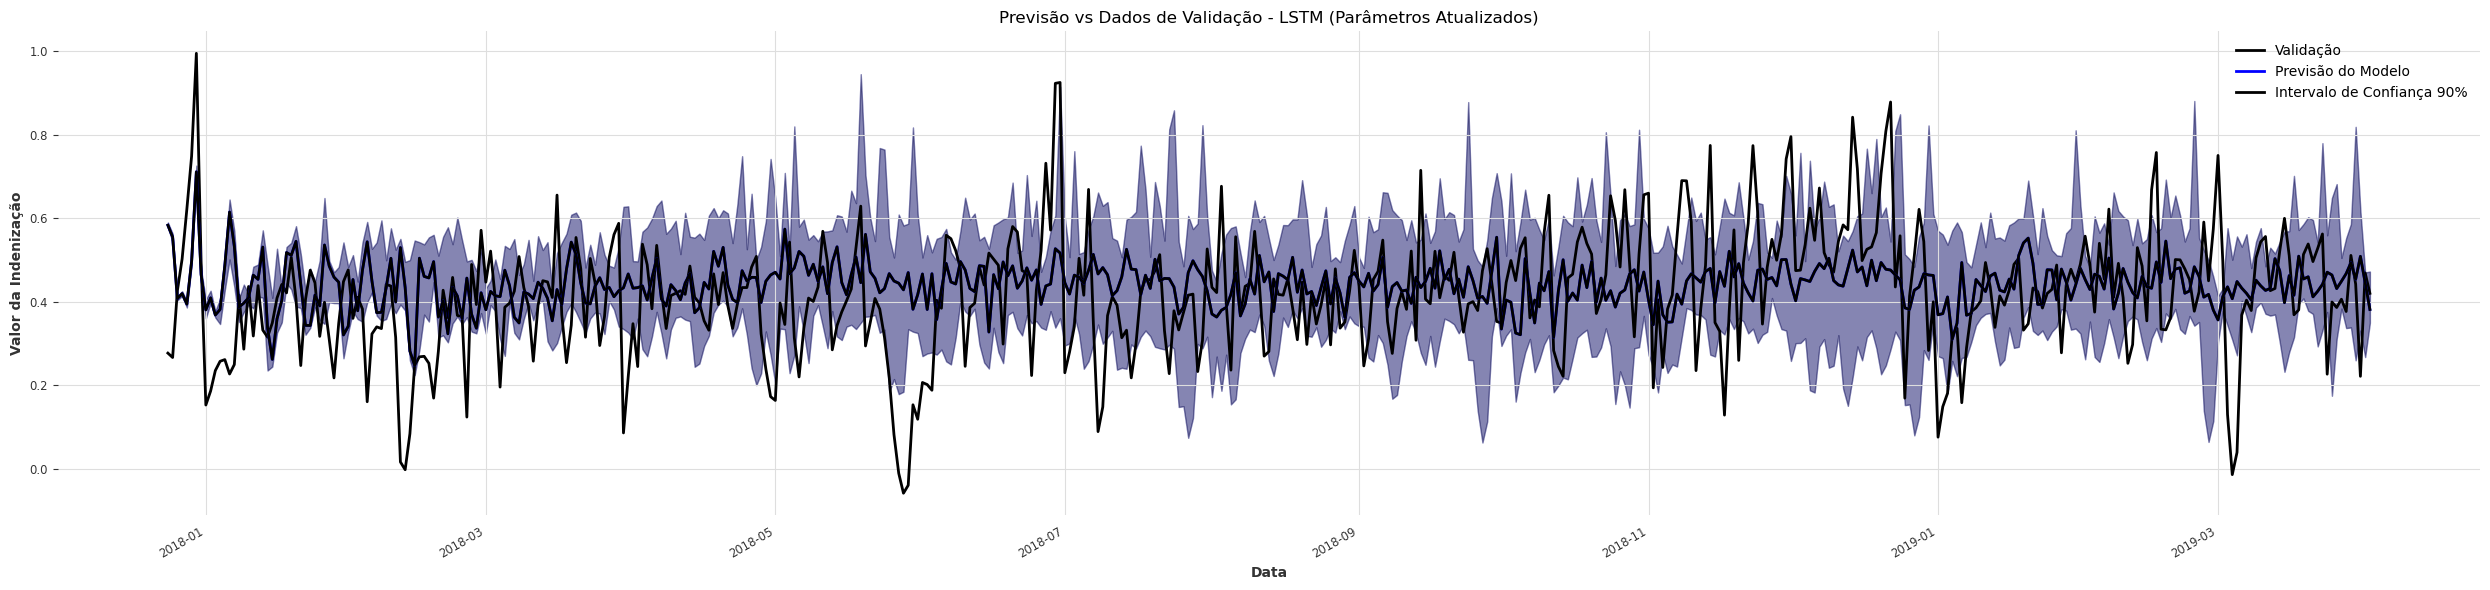

In [17]:
# Faz previsões no conjunto de validação
y_pred_val = best_lstm_model.predict(n=len(val_continuous_scaled), num_samples=50, future_covariates=all_future_covariates)

# Plota os dados reais e as previsões
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))
val_continuous_scaled['INDENIZ'].plot(label='Validação',color='black')
y_pred_val.plot(label='Previsão do Modelo',color='blue')
# Plota a área sombreada com base nos quantis 5% e 95% (representando a incerteza)
y_pred_val.plot(low_quantile=0.05, high_quantile=0.95, label='Intervalo de Confiança 90%', alpha=0.3)

plt.title('Previsão vs Dados de Validação - LSTM (Parâmetros Atualizados)')
plt.xlabel('Data')
plt.ylabel('Valor da Indenização')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(paste_graph,'Previsao_vs_Dados_Val.png'))
plt.savefig(os.path.join(paste_graph,'Previsao_vs_Dados_Val.pdf'))
plt.show()

In [18]:
# Calcula as métricas usando os dados de validação e as previsões
mse_val = mse(val_continuous_scaled['INDENIZ'], y_pred_val)
rmse_val = rmse(val_continuous_scaled['INDENIZ'], y_pred_val)
rmsle_val = rmsle(val_continuous_scaled['INDENIZ'], y_pred_val)
mae_val = mae(val_continuous_scaled['INDENIZ'], y_pred_val)
mape_val = mape(val_continuous_scaled['INDENIZ'], y_pred_val)
smape_val = smape(val_continuous_scaled['INDENIZ'], y_pred_val)

# Calcula Quantile Loss (QL) para q=0.25, 0.5, 0.75
ql_025_val = ql(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.25)
ql_050_val = ql(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.5)
ql_075_val = ql(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.75)

# Calcula Quantile Risk (QR) para q=0.25, 0.5, 0.75
qr_025_val = qr(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.25)
qr_050_val = qr(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.5)
qr_075_val = qr(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.75)


# Organiza as métricas em um DataFrame
metrics_data_cal = {
    'Métricas': ['MSE', 'RMSE', 'RMSLE', 'MAE', 'MAPE', 'SMAPE',
                 'QL (q=0.25)', 'QL (q=0.5)', 'QL (q=0.75)',
                 'QR (q=0.25)', 'QR (q=0.5)', 'QR (q=0.75)'],
    'Validação': [mse_val, rmse_val, rmsle_val, mae_val, mape_val, smape_val,
                  ql_025_val, ql_050_val, ql_075_val,
                  qr_025_val, qr_050_val, qr_075_val]
}

# Cria o DataFrame
metrics_val = pd.DataFrame(metrics_data_cal)

# Exibe o DataFrame
metrics_val


Métricas                                          Validação
0           MSE                                           0.023739
1          RMSE                                           0.154075
2         RMSLE                                           0.111456
3           MAE                                           0.115662
4          MAPE                                         113.287716
5         SMAPE                                          29.513159
6   QL (q=0.25)  [0.45664273079503886, 0.42760303684181156, 0.0...
7    QL (q=0.5)  [0.30627842489083323, 0.2886641719108539, 0.01...
8   QL (q=0.75)  [0.15528194879643298, 0.14527287699025726, 0.0...
9   QR (q=0.25)                                           0.048078
10   QR (q=0.5)                                           0.058489
11  QR (q=0.75)                                           0.047996

# Conformal Prediction


Implementa a calibração via Conformal Prediction para ajustar os intervalos de confiança das previsões do modelo LSTM.

**Processo em 4 etapas:**

1. **Calibração Inicial**  
   - Gera previsões probabilísticas (50 amostras) para o conjunto de calibração  
   - Calcula resíduos entre valores reais e previstos  
   - Determina quantis 2.5% e 97.5% dos resíduos para intervalos de 95% confiança  

2. **Aplicação no Teste**  
   - Produz previsões para o conjunto final de teste  
   - Aplica os intervalos calibrados (lower/upper bound)  
   - Calcula taxa de cobertura real (95.24% no exemplo)  

3. **Avaliação Quantitativa**  
   - Compara métricas em validação/calibração/teste  
   - Inclui 12 métricas de erro e desempenho quantílico  

4. **Visualização**  
   - Gráfico comparativo com:  
     - Valores reais (preto)  
     - Previsões pontuais (vermelho)  
     - Intervalos calibrados (azul)  

**Resultados Destacados:**  
- Dataframe `metrics_combined` com desempenho comparativo  
- Gráficos salvos em PNG/PDF (`cal_series.*`)  
- Taxa de cobertura dentro do esperado (~95%)

**Técnica Avançada:**  
O Conformal Prediction garante cobertura estatística válida mesmo com distribuições não normais dos erros.

## Calibração

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Predicting: |                                                                                    | 0/? [00:00<…

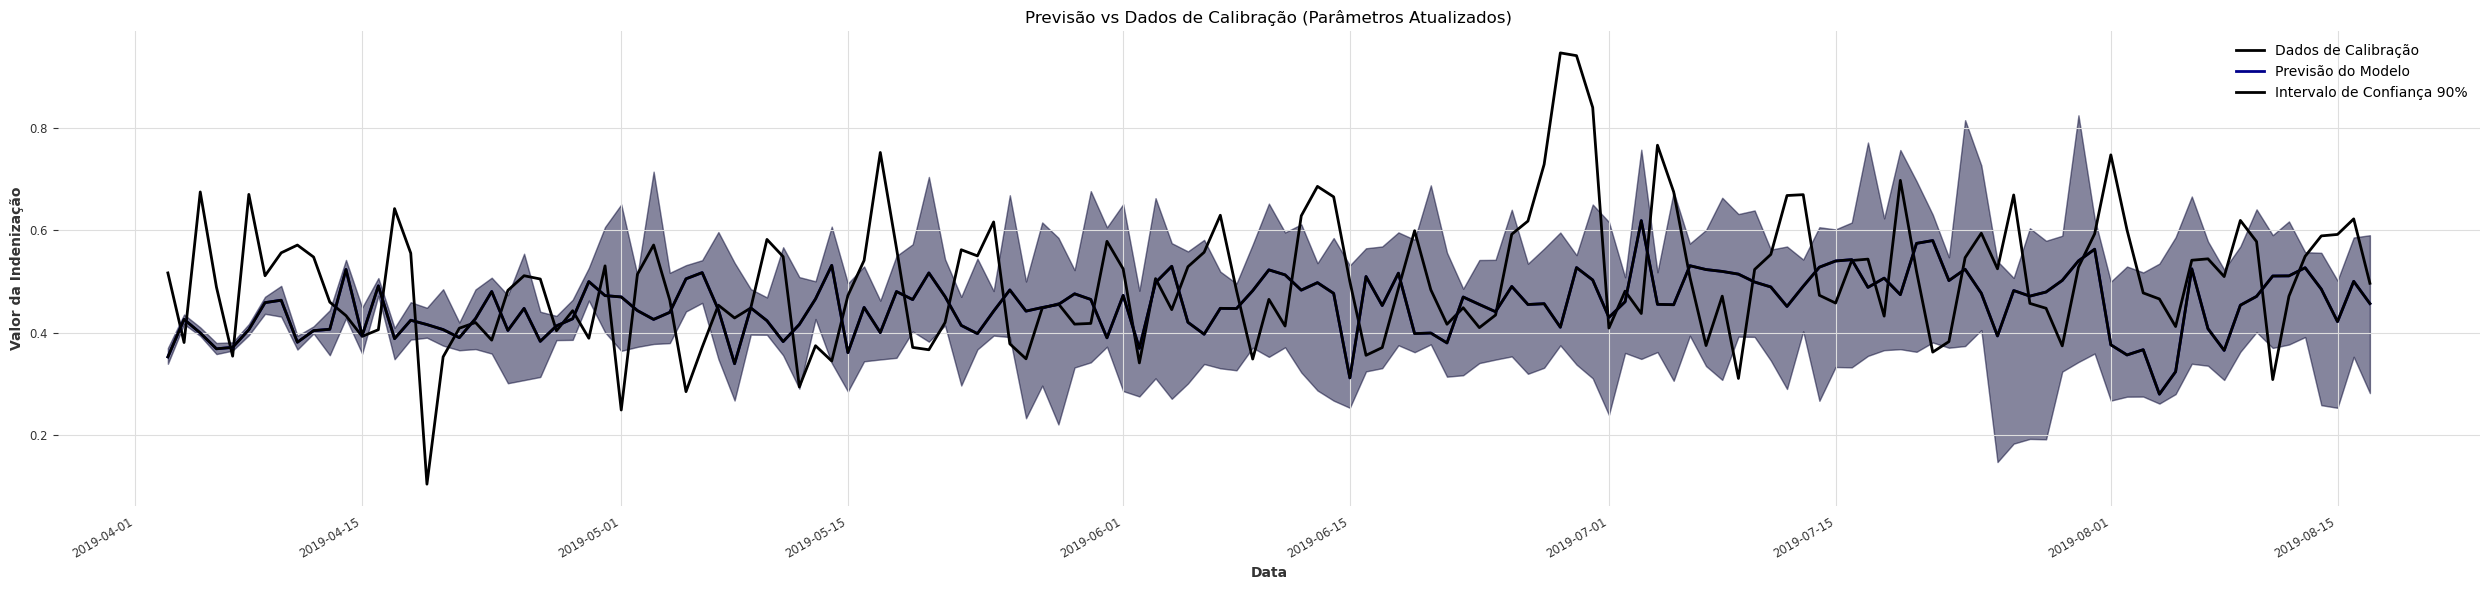

In [19]:
num_samples=50
# Ponto final da série de validação
last_point_of_val = val_continuous_scaled.end_time()

# Faz previsões no conjunto de calibração a partir do último ponto da validação
y_pred_cal = best_lstm_model.predict(
    n=len(cal_continuous_scaled),
    num_samples=num_samples,
    series=val_continuous_scaled,  # Iniciar a previsão a partir do fim da validação
    future_covariates=all_future_covariates
)

# Plota os dados de calibração e as previsões
plt.figure(figsize=(25, 6))
cal_continuous_scaled['INDENIZ'].plot(label='Dados de Calibração', color='black')
y_pred_cal.plot(label='Previsão do Modelo', color='darkblue')

# Plota a área sombreada com base nos quantis 5% e 95% (representando a incerteza)
y_pred_cal.plot(low_quantile=0.05, high_quantile=0.95, label='Intervalo de Confiança 90%', alpha=0.3)

plt.title('Previsão vs Dados de Calibração (Parâmetros Atualizados)')
plt.xlabel('Data')
plt.ylabel('Valor da Indenização')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(paste_graph,'Previsao_vs_Dados_Cal.png'))
plt.savefig(os.path.join(paste_graph,'Previsao_vs_Dados_Cal.pdf'))
plt.show()


In [20]:
# Calcula as métricas usando os dados de validação e as previsões
mse_val = mse(val_continuous_scaled['INDENIZ'], y_pred_val)
rmse_val = rmse(val_continuous_scaled['INDENIZ'], y_pred_val)
rmsle_val = rmsle(val_continuous_scaled['INDENIZ'], y_pred_val)
mae_val = mae(val_continuous_scaled['INDENIZ'], y_pred_val)
mape_val = mape(val_continuous_scaled['INDENIZ'], y_pred_val)
smape_val = smape(val_continuous_scaled['INDENIZ'], y_pred_val)

# Calcula o Quantile Loss (QL) para q=0.25, 0.5, 0.75
ql_025_val = ql(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.25)
ql_050_val = ql(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.5)
ql_075_val = ql(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.75)

# Calcula o Quantile Risk (QR) para q=0.25, 0.5, 0.75
qr_025_val = qr(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.25)
qr_050_val = qr(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.5)
qr_075_val = qr(val_continuous_scaled['INDENIZ'], y_pred_val, q=0.75)


# Organiza as métricas em um DataFrame
metrics_data = {
    'Métricas': ['MSE', 'RMSE', 'RMSLE', 'MAE', 'MAPE', 'SMAPE',
                 'QL (q=0.25)', 'QL (q=0.5)', 'QL (q=0.75)',
                 'QR (q=0.25)', 'QR (q=0.5)', 'QR (q=0.75)'],
    'Calibração': [mse_val, rmse_val, rmsle_val, mae_val, mape_val, smape_val,
                  ql_025_val, ql_050_val, ql_075_val,
                  qr_025_val, qr_050_val, qr_075_val]
}

# Cria o DataFrame
metrics_cal = pd.DataFrame(metrics_data)

# Exibe o DataFrame
metrics_cal


Métricas                                         Calibração
0           MSE                                           0.023739
1          RMSE                                           0.154075
2         RMSLE                                           0.111456
3           MAE                                           0.115662
4          MAPE                                         113.287716
5         SMAPE                                          29.513159
6   QL (q=0.25)  [0.45664273079503886, 0.42760303684181156, 0.0...
7    QL (q=0.5)  [0.30627842489083323, 0.2886641719108539, 0.01...
8   QL (q=0.75)  [0.15528194879643298, 0.14527287699025726, 0.0...
9   QR (q=0.25)                                           0.048078
10   QR (q=0.5)                                           0.058489
11  QR (q=0.75)                                           0.047996

## Métricas para **os Dados de Teste** com Regiões de Conformidade

In [21]:
# Reescala as previsões do conjunto de calibração para a escala original
y_pred_cal_rescaled = scaler.inverse_transform(y_pred_cal)['INDENIZ']

# Compara com os valores reais não reescalonados no conjunto de calibração
y_cal_rescaled = cal_series_univariate.values().flatten()

# Calcula os resíduos no conjunto de calibração
residuals_cal = y_cal_rescaled - y_pred_cal_rescaled.values().flatten()

# Calcula os quantis dos resíduos
lower_quantile = np.percentile(residuals_cal, 2.5)  # 2.5% para o limite inferior (95% de confiança)
upper_quantile = np.percentile(residuals_cal, 97.5)  # 97.5% para o limite superior (95% de confiança)

# Exibe os quantis
print(f"Lower Quantile (2.5%): {lower_quantile}")
print(f"Upper Quantile (97.5%): {upper_quantile}")


Lower Quantile (2.5%): -3927127.1461046734
Upper Quantile (97.5%): 7881811.117504749


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Predicting: |                                                                                    | 0/? [00:00<…

Taxa de cobertura dos intervalos de confiança: 82.35%


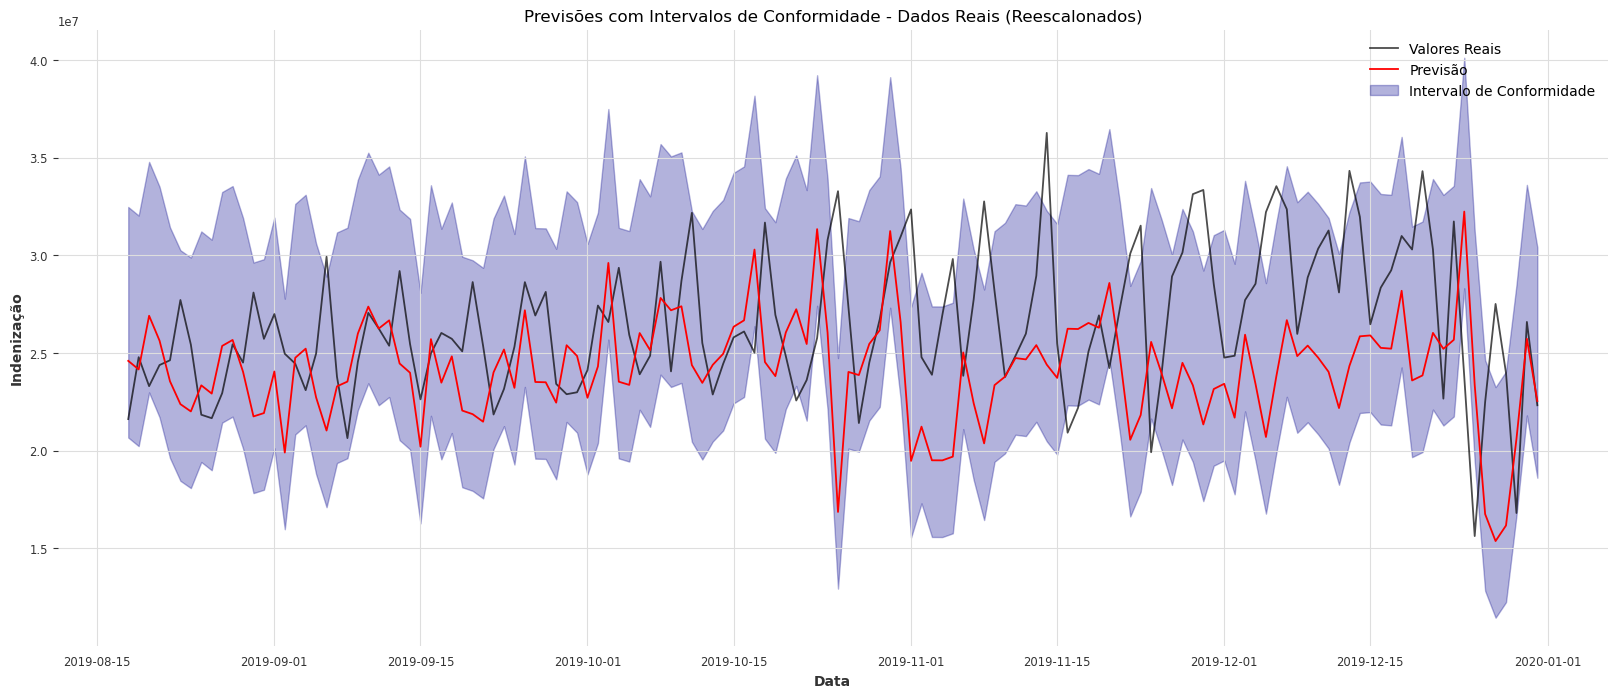

In [22]:
num_samples = num_samples

# Faz previsões no conjunto de teste final a partir do fim da calibração
y_pred_test = best_lstm_model.predict(
    n=len(test_continuous_scaled),
    num_samples=num_samples,
    series=cal_continuous_scaled,  # Inicia a previsão a partir do fim da calibração
    future_covariates=all_future_covariates
)

# Reescala as previsões do conjunto de teste para a escala original
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)['INDENIZ']

# Compara com os valores reais não reescalonados no conjunto de teste (usando test_final_series para valores reais)
y_test_rescaled = test_final_series_univariate.values().flatten()

# Gera os intervalos de conformidade com base nos quantis dos resíduos
lower_bound_test = y_pred_test_rescaled.values().flatten() + lower_quantile
upper_bound_test = y_pred_test_rescaled.values().flatten() + upper_quantile

# Calcula a taxa de cobertura
coverage = ((y_test_rescaled >= lower_bound_test) & (y_test_rescaled <= upper_bound_test)).mean()
print(f"Taxa de cobertura dos intervalos de confiança: {coverage * 100:.2f}%")

# Plota as previsões, intervalos de confiança e valores reais (usando test_final_series)
plt.figure(figsize=(20, 8))
plt.plot(test_final_series.time_index, y_test_rescaled, label='Valores Reais', color='black', alpha=0.7 )
plt.plot(test_final_series.time_index, y_pred_test_rescaled.values().flatten(), label='Previsão', color='red')
# Plota a área sombreada com base nos quantis 5% e 95% (representando a incerteza)
plt.fill_between(test_final_series.time_index, lower_bound_test, upper_bound_test, color='darkblue', alpha=0.3, label='Intervalo de Conformidade')

plt.title('Previsões com Intervalos de Conformidade - Dados Reais (Reescalonados)')
plt.xlabel('Data')
plt.ylabel('Indenização')
plt.legend()
cal_series_ = os.path.join(paste_graph, "cal_series.pdf")
cal_series_png = os.path.join(paste_graph, "cal_series.png")
plt.savefig(cal_series_, facecolor='lightgrey', bbox_inches='tight')
plt.savefig(cal_series_png, facecolor='lightgrey', bbox_inches='tight')
plt.show()


In [23]:
# Calcula as métricas usando os dados de teste e as previsões
mse_test = mse(test_continuous_scaled['INDENIZ'], y_pred_test)
rmse_test = rmse(test_continuous_scaled['INDENIZ'], y_pred_test)
rmsle_test = rmsle(test_continuous_scaled['INDENIZ'], y_pred_test)
mae_test = mae(test_continuous_scaled['INDENIZ'], y_pred_test)
mape_test = mape(test_continuous_scaled['INDENIZ'], y_pred_test)
smape_test = smape(test_continuous_scaled['INDENIZ'], y_pred_test)
ql_test_50 = ql(test_continuous_scaled['INDENIZ'], y_pred_test, q=0.5)
ql_test_25 = ql(test_continuous_scaled['INDENIZ'], y_pred_test, q=0.25)
ql_test_75 = ql(test_continuous_scaled['INDENIZ'], y_pred_test, q=0.75)
qr_test_50 = qr(test_continuous_scaled['INDENIZ'], y_pred_test, q=0.5)
qr_test_25 = qr(test_continuous_scaled['INDENIZ'], y_pred_test, q=0.25)
qr_test_75 = qr(test_continuous_scaled['INDENIZ'], y_pred_test, q=0.75)

# Organiza as métricas de teste em um DataFrame
metrics_test_data = {
    'Métricas': ['MSE', 'RMSE', 'RMSLE', 'MAE', 'MAPE', 'SMAPE', 'QL (0.5)', 'QL (0.25)', 'QL (0.75)', 'QR (0.5)', 'QR (0.25)', 'QR (0.75)'],
    'Teste': [mse_test, rmse_test, rmsle_test, mae_test, mape_test, smape_test, ql_test_50, ql_test_25, ql_test_75, qr_test_50, qr_test_25, qr_test_75]
}

# Cria o DataFrame para as métricas de teste
metrics_test = pd.DataFrame(metrics_test_data)
metrics_test



Métricas                                              Teste
0         MSE                                           0.046757
1        RMSE                                           0.216233
2       RMSLE                                           0.136277
3         MAE                                           0.164626
4        MAPE                                          27.707476
5       SMAPE                                          29.768922
6    QL (0.5)  [0.13558741425593213, 0.02344752492570007, 0.1...
7   QL (0.25)  [0.20105491228251376, 0.012517448757950744, 0....
8   QL (0.75)  [0.06904213572611306, 0.032209032288705, 0.084...
9    QR (0.5)                                           0.207254
10  QR (0.25)                                           0.117509
11  QR (0.75)                                           0.266047

**Coluna Geral de Resultados**

In [24]:
# Certifica que a coluna 'Métricas' seja a chave comum para a junção
metrics_combined = pd.merge(metrics_val, metrics_cal, on='Métricas', how='outer', suffixes=('_val', '_cal'))
metrics_combined['Teste'] = metrics_test['Teste']
metrics_combined

Métricas                                          Validação  \
0           MSE                                           0.023739   
1          RMSE                                           0.154075   
2         RMSLE                                           0.111456   
3           MAE                                           0.115662   
4          MAPE                                         113.287716   
5         SMAPE                                          29.513159   
6   QL (q=0.25)  [0.45664273079503886, 0.42760303684181156, 0.0...   
7    QL (q=0.5)  [0.30627842489083323, 0.2886641719108539, 0.01...   
8   QL (q=0.75)  [0.15528194879643298, 0.14527287699025726, 0.0...   
9   QR (q=0.25)                                           0.048078   
10   QR (q=0.5)                                           0.058489   
11  QR (q=0.75)                                           0.047996   

                                           Calibração  \
0                                            0.023739   
1                                            0.154075   
2                                            0.111456   
3                                            0.115662   
4                                          113.287716   
5                                           29.513159   
6   [0.45664273079503886, 0.42760303684181156, 0.0...   
7   [0.30627842489083323, 0.2886641719108539, 0.01...   
8   [0.15528194879643298, 0.14527287699025726, 0.0...   
9                                            0.048078   
10                                           0.058489   
11                                           0.047996   

                                                Teste  
0                                            0.046757  
1                                            0.216233  
2                                            0.136277  
3                                            0.164626  
4                                           27.707476  
5                                           29.768922  
6   [0.13558741425593213, 0.02344752492570007, 0.1...  
7   [0.20105491228251376, 0.012517448757950744, 0....  
8   [0.06904213572611306, 0.032209032288705, 0.084...  
9                                            0.207254  
10                                           0.117509  
11                                           0.266047

# Análises dos Resultados


**Descrição da Análise de Resultados**

1. **Processamento dos Dados**  
   - Concatenação das séries temporais (validação, calibração e teste) em arrays únicos  
   - Conversão para escala original usando `inverse_transform`  
   - Verificação de consistência nos tamanhos dos arrays  

2. **Visualizações Geradas**  
   - Gráfico interativo (Plotly) com:  
     - Valores reais vs previstos  
     - Intervalos de conformidade  
     - Divisão das fases (validação/calibração/teste)  
   - Versões estáticas (Matplotlib) em PDF/PNG  
   - Configurações:  
     - Eixo y em escala logarítmica  
     - Cores específicas para cada elemento  
     - Anotações das fases  

3. **Métricas Calculadas**  
   - DataFrame `metrics_combined` contendo:  
     - Erros (RMSE, MAE)  
     - Métricas quantílicas (QL, QR)  
     - Comparação entre conjuntos  

4. **Arquivos de Saída**  
   - Gráficos:  
     - `val_cal_test_series.html` (interativo)  
     - `val_cal_test_series.pdf/png` (estático)  
     - `cal_test_series.pdf/png` (foco calibração-teste)  
   - Dados:  
     - Séries temporais concatenadas  
     - Intervalos de confiança calculados  

**Verificações Realizadas**  
- Compatibilidade nos tamanhos dos arrays temporais  
- Cálculo preciso dos intervalos de conformidade  
- Exportação correta dos arquivos gráficos  
```

In [25]:
# Faz previsões no conjunto de validação
y_pred_val_rescaled = scaler.inverse_transform(y_pred_val)['INDENIZ']
y_val_rescaled = val_series_univariate.values().flatten()

# Faz previsões no conjunto de calibração a partir do fim da validação
y_pred_cal_rescaled = scaler.inverse_transform(y_pred_cal)['INDENIZ']
y_cal_rescaled = cal_series_univariate.values().flatten()

# Faz previsões no conjunto de teste a partir do fim da calibração
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)['INDENIZ']
y_test_rescaled = test_final_series_univariate.values().flatten()

# Concatena os valores reais e preditos para validação, calibração e teste
y_real_concat = np.concatenate([train_series['INDENIZ'].values().flatten(), y_val_rescaled, y_cal_rescaled, y_test_rescaled])
y_pred_concat = np.concatenate([y_pred_val_rescaled.values().flatten(), y_pred_cal_rescaled.values().flatten(), y_pred_test_rescaled.values().flatten()])

# Gera os intervalos de conformidade (com base nos resíduos da calibração ou teste)
lower_bound_concat = np.concatenate([y_pred_val_rescaled.values().flatten(), y_pred_cal_rescaled.values().flatten(), lower_bound_test])
upper_bound_concat = np.concatenate([y_pred_val_rescaled.values().flatten(), y_pred_cal_rescaled.values().flatten(), upper_bound_test])

# Concatena os índices de tempo para as séries
time_index_concat = np.concatenate([train_series.time_index, val_series.time_index, cal_series.time_index, test_final_series.time_index])

# Verifica o comprimento dos índices e das séries
print(f"Comprimento do time_index_concat: {len(time_index_concat)}")
print(f"Comprimento de y_real_concat: {len(y_real_concat)}")
print(f"Comprimento de y_pred_concat: {len(y_pred_concat)}")
print(f"Comprimento de lower_bound_concat: {len(lower_bound_concat)}")
print(f"Comprimento de upper_bound_concat: {len(upper_bound_concat)}")

# Caso as previsões não cubram todo o período de tempo, ajuste os índices de tempo
# Ajuste o comprimento dos índices de tempo para corresponder ao número de previsões
time_index_concat_adjusted = time_index_concat[-len(y_pred_concat):]

Comprimento do time_index_concat: 1826
Comprimento de y_real_concat: 1826
Comprimento de y_pred_concat: 738
Comprimento de lower_bound_concat: 738
Comprimento de upper_bound_concat: 738


**Validação, Calibração e Teste**

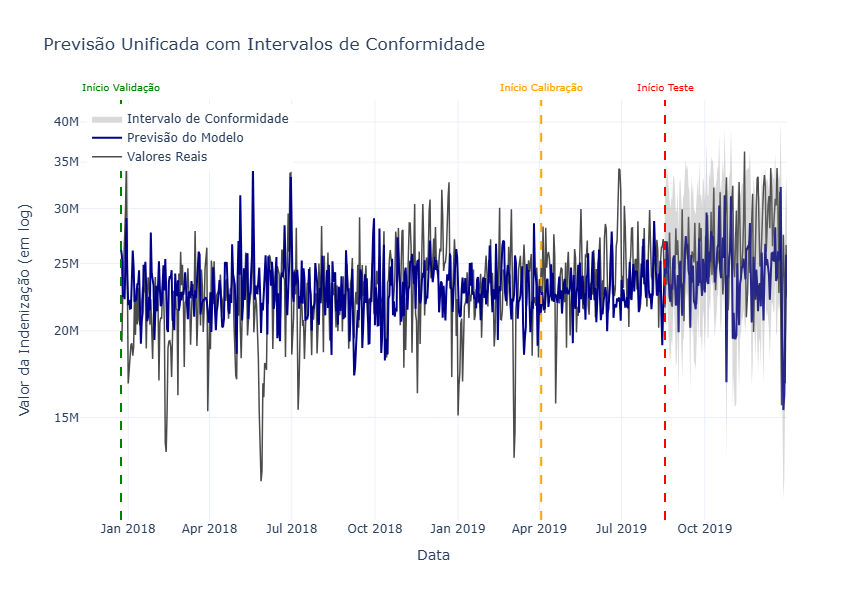

In [26]:
import plotly.graph_objects as go
import numpy as np
import os
from datetime import datetime

# Função para converter timestamp para string ISO formatada
def convert_to_iso(ts):
    return ts.isoformat() if hasattr(ts, 'isoformat') else str(ts)

# Cria figura
fig = go.Figure()

# Converte índices de tempo para strings ISO
time_index_concat_adjusted_iso = [convert_to_iso(ts) for ts in time_index_concat_adjusted]

# Adiciona traços (convertendo para strings ISO)
fig.add_trace(go.Scatter(
    x=time_index_concat_adjusted_iso,
    y=y_real_concat[-len(time_index_concat_adjusted):],
    name='Valores Reais',
    line=dict(color='black', width=1.5),
    opacity=0.7
))

fig.add_trace(go.Scatter(
    x=time_index_concat_adjusted_iso,
    y=y_pred_concat,
    name='Previsão do Modelo',
    line=dict(color='darkblue', width=2)
))

# Adiciona intervalo de confiança
fig.add_trace(go.Scatter(
    x=time_index_concat_adjusted_iso,
    y=upper_bound_concat[:len(time_index_concat_adjusted)],
    fill=None,
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=time_index_concat_adjusted_iso,
    y=lower_bound_concat[:len(time_index_concat_adjusted)],
    fill='tonexty',
    mode='lines',
    line=dict(width=0),
    fillcolor='rgba(128,128,128,0.3)',
    name='Intervalo de Conformidade'
))

# Adiciona linhas verticais como shapes (sem usar add_vline)
phases = [
    (convert_to_iso(val_series.start_time()), 'green', 'Início Validação'),
    (convert_to_iso(cal_series.start_time()), 'orange', 'Início Calibração'),
    (convert_to_iso(test_final_series.start_time()), 'red', 'Início Teste')
]

for date, color, name in phases:
    fig.add_shape(
        type="line",
        x0=date, x1=date,
        y0=0, y1=1,
        yref="paper",
        line=dict(color=color, dash='dash', width=2)
    )
    # Adiciona anotação separadamente
    fig.add_annotation(
        x=date,
        y=1.05,
        yref="paper",
        text=name,
        showarrow=False,
        font=dict(size=10, color=color)
    )

# Adiciona textos das fases (convertendo para strings ISO)
mid_val = convert_to_iso(val_continuous_scaled.time_index[int(len(val_continuous_scaled)/2)])
mid_cal = convert_to_iso(cal_continuous_scaled.time_index[int(len(cal_continuous_scaled)/2)])
mid_test = convert_to_iso(test_final_series.time_index[int(len(test_final_series)/2)])

fig.add_annotation(
    x=mid_val,
    y=max(y_real_concat)*1.3,
    text="Validação",
    showarrow=False,
    font=dict(size=12)
)

fig.add_annotation(
    x=mid_cal,
    y=max(y_real_concat)*1.3,
    text="Calibração",
    showarrow=False,
    font=dict(size=12)
)

fig.add_annotation(
    x=mid_test,
    y=max(y_real_concat)*1.3,
    text="Teste",
    showarrow=False,
    font=dict(size=12)
)

# Configurações do layout
fig.update_layout(
    title='Previsão Unificada com Intervalos de Conformidade',
    xaxis_title='Data',
    yaxis_title='Valor da Indenização (em log)',
    yaxis_type="log",
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    height=600,
    width=1200
)

# Salva como HTML
html_path = os.path.join(paste_graph, "val_cal_test_series.html")
fig.write_html(html_path)

# Mostra figura
fig.show()

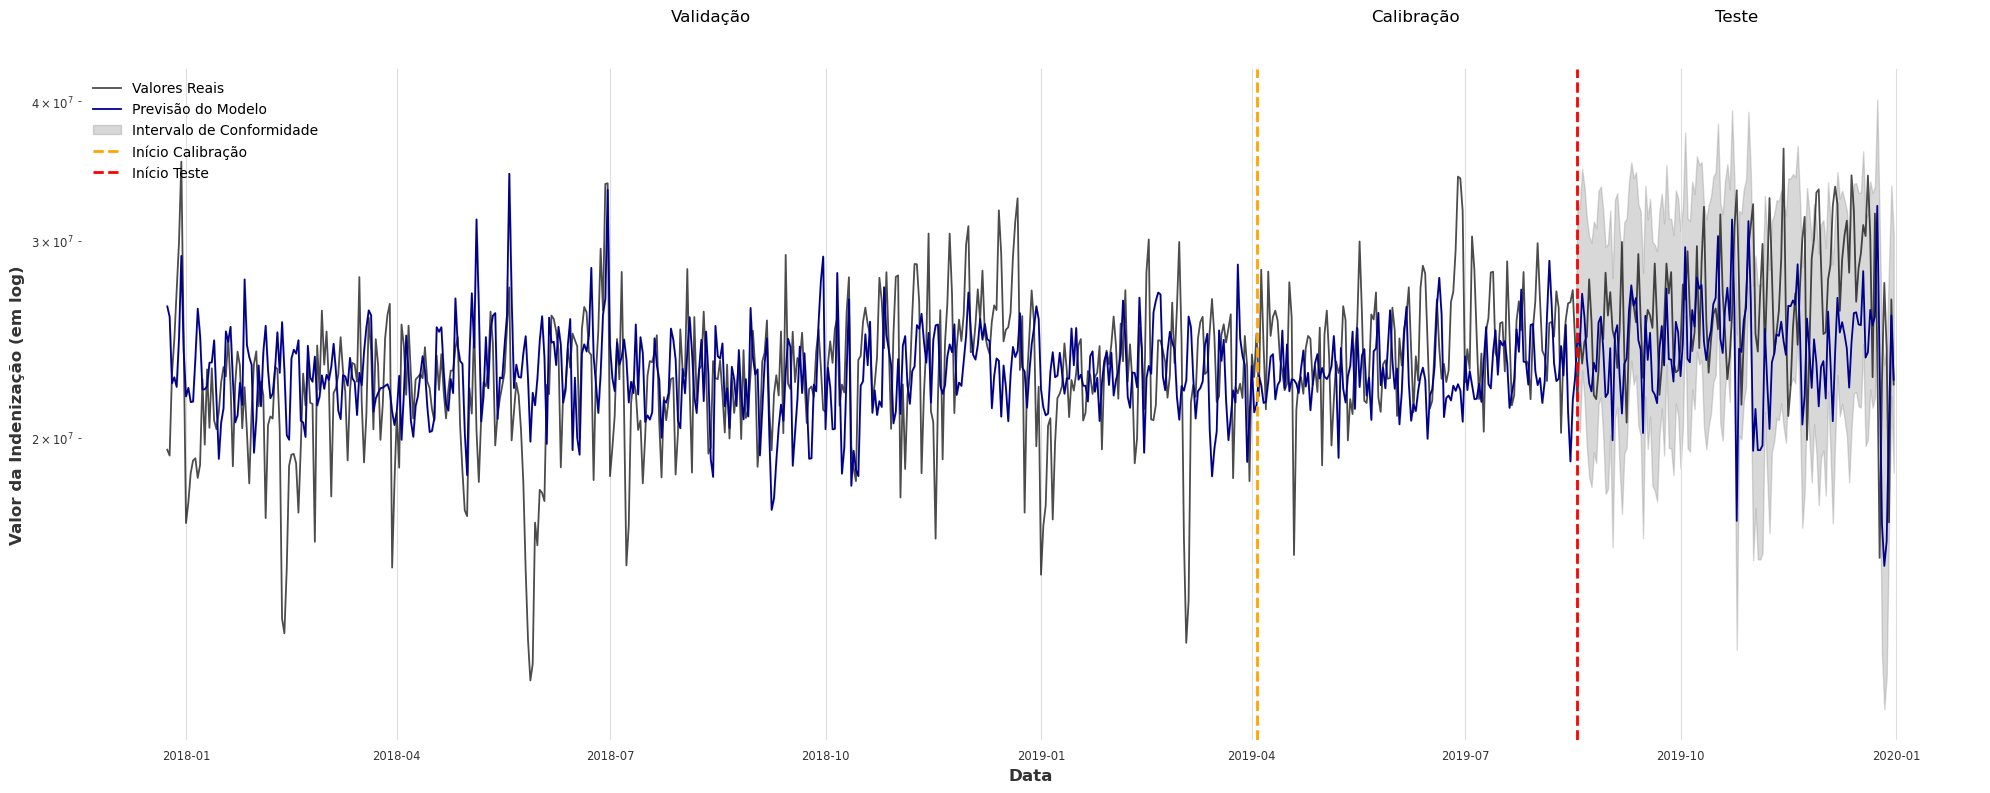

In [27]:
# Plota o gráfico
plt.figure(figsize=(20, 8))

# Plota os dados reais e as previsões
plt.plot(time_index_concat_adjusted, y_real_concat[-len(time_index_concat_adjusted):], label='Valores Reais', color='black',alpha=0.7)

# Plota os dados reais completos (antes e durante as previsões)
# plt.plot(time_index_concat, y_real_concat, label='Valores Reais (Treino e Previsão)', color='black')

plt.plot(time_index_concat_adjusted, y_pred_concat, label='Previsão do Modelo', color='darkblue')

# Plota os intervalos de confiança (área sombreada)
plt.fill_between(time_index_concat_adjusted, lower_bound_concat[:len(time_index_concat_adjusted)], upper_bound_concat[:len(time_index_concat_adjusted)], color='gray', alpha=0.3, label='Intervalo de Conformidade')

# Marca as fases do modelo (Treino, Validação, Calibração, Teste)
# plt.axvline(x=val_series.start_time(), color='green', linestyle='--', label='Início Validação',alpha=1,linewidth=2)
plt.axvline(x=cal_series.start_time(), color='orange', linestyle='--', label='Início Calibração',alpha=1,linewidth=2)
plt.axvline(x=test_final_series.start_time(), color='red', linestyle='--', label='Início Teste',alpha=1,linewidth=2)

# Adiciona o texto "Validação"
plt.text(x=val_continuous_scaled.time_index[int(len(val_continuous_scaled) / 2)],
         y=max(y_real_concat) * 1.3,  # Ajusta a posição vertical acima dos valores
         s="Validação", fontsize=12, color='black', ha='center')

# Adiciona o texto "Calibração"
plt.text(x=cal_continuous_scaled.time_index[int(len(cal_continuous_scaled) / 2)],
         y=max(y_real_concat) * 1.3,
         s="Calibração", fontsize=12, color='black', ha='center')

# Adiciona o texto "Teste"
plt.text(x=test_final_series.time_index[int(len(test_final_series) / 2)],
         y=max(y_real_concat) * 1.3,
         s="Teste", fontsize=12, color='black', ha='center')


# plt.title('Previsão Unificada (Treino, Validação, Calibração e Teste) com Intervalos de Conformidade')
plt.xlabel('Data',fontsize=12, fontweight='bold')
plt.ylabel('Valor da Indenização (em log)',fontsize=12, fontweight='bold')
plt.yscale('log')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
save_val_cal_test = os.path.join(paste_graph, "val_cal_test_series.pdf")
plt.savefig(save_val_cal_test, facecolor='lightgrey', bbox_inches='tight')
save_val_cal_test_png = os.path.join(paste_graph, "val_cal_test_series.png")
plt.savefig(save_val_cal_test_png, facecolor='lightgrey', bbox_inches='tight')
plt.show()


**Calibração e Teste**

Comprimento do time_index_concat: 273
Comprimento de y_real_concat: 273
Comprimento de y_pred_concat: 273
Comprimento de lower_bound_concat: 273
Comprimento de upper_bound_concat: 273


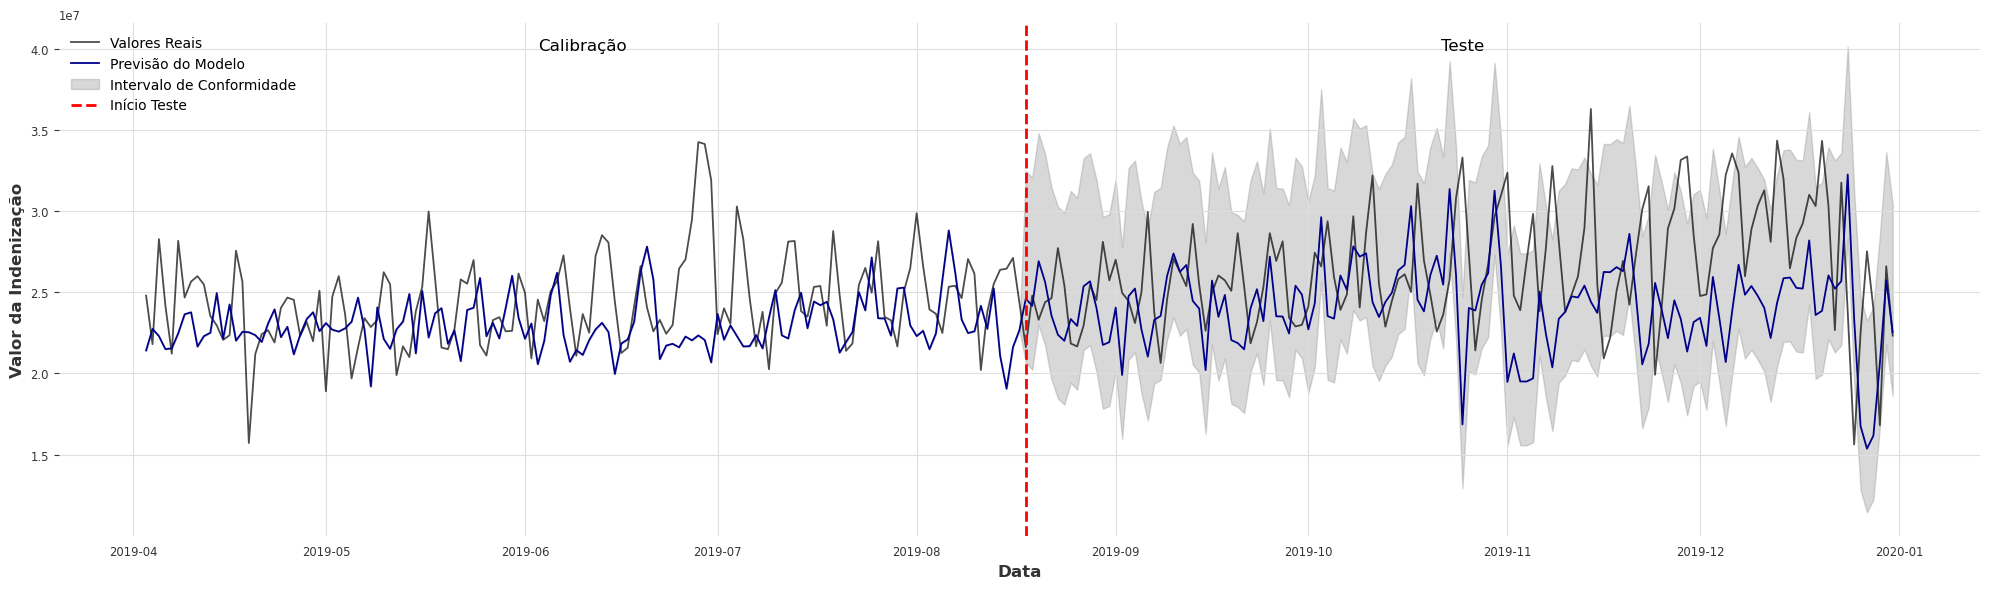

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Faz previsões no conjunto de calibração a partir do fim da validação
y_pred_cal_rescaled = scaler.inverse_transform(y_pred_cal)['INDENIZ']
y_cal_rescaled = cal_series_univariate.values().flatten()

# Faz previsões no conjunto de teste a partir do fim da calibração
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)['INDENIZ']
y_test_rescaled = test_final_series_univariate.values().flatten()

# Concatena os valores reais e preditos para calibração e teste
y_real_concat = np.concatenate([y_cal_rescaled, y_test_rescaled])
y_pred_concat = np.concatenate([y_pred_cal_rescaled.values().flatten(), y_pred_test_rescaled.values().flatten()])

# Gera os intervalos de conformidade (com base nos resíduos da calibração ou teste)
lower_bound_concat = np.concatenate([y_pred_cal_rescaled.values().flatten(), lower_bound_test])
upper_bound_concat = np.concatenate([y_pred_cal_rescaled.values().flatten(), upper_bound_test])

# Concatena os índices de tempo para as séries a partir da calibração
time_index_concat = np.concatenate([cal_series.time_index, test_final_series.time_index])

# Verifica o comprimento dos índices e das séries
print(f"Comprimento do time_index_concat: {len(time_index_concat)}")
print(f"Comprimento de y_real_concat: {len(y_real_concat)}")
print(f"Comprimento de y_pred_concat: {len(y_pred_concat)}")
print(f"Comprimento de lower_bound_concat: {len(lower_bound_concat)}")
print(f"Comprimento de upper_bound_concat: {len(upper_bound_concat)}")

# Plota o gráfico a partir da calibração
plt.figure(figsize=(20, 6))

# Plota os dados reais e as previsões
plt.plot(time_index_concat, y_real_concat, label='Valores Reais', color='black',alpha=0.7)
plt.plot(time_index_concat, y_pred_concat, label='Previsão do Modelo', color='darkblue')

# Plota os intervalos de confiança (área sombreada)
plt.fill_between(time_index_concat, lower_bound_concat[:len(time_index_concat)], upper_bound_concat[:len(time_index_concat)], color='gray', alpha=0.3, label='Intervalo de Conformidade')

# Marca as fases do modelo (Calibração, Teste)
# plt.axvline(x=cal_series.start_time(), color='orange', linestyle='--', label='Início Calibração',alpha=1,linewidth=2)
plt.axvline(x=test_final_series.start_time(), color='red', linestyle='--', label='Início Teste',alpha=1,linewidth=2)

# Adiciona o texto "Calibração"
plt.text(x=cal_continuous_scaled.time_index[int(len(cal_continuous_scaled) / 2)],
         y=max(y_real_concat) * 1.1,
         s="Calibração", fontsize=12, color='black', ha='center')

# Adiciona o texto "Teste"
plt.text(x=test_final_series.time_index[int(len(test_final_series) / 2)],
         y=max(y_real_concat) * 1.1,
         s="Teste", fontsize=12, color='black', ha='center')

plt.xlabel('Data',fontsize=12, fontweight='bold')
plt.ylabel('Valor da Indenização',fontsize=12, fontweight='bold')
# plt.yscale('log')
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()

# Salva o gráfico
save_cal_test = os.path.join(paste_graph, "cal_test_series.pdf")
plt.savefig(save_cal_test, facecolor='lightgrey', bbox_inches='tight')

save_cal_test_png = os.path.join(paste_graph, "cal_test_series.png")
plt.savefig(save_cal_test_png, facecolor='lightgrey', bbox_inches='tight')

plt.show()


# Prêmio Puro Calibrado

Após a construção dos intervalos de conformidade para cada ponto no tempo $t$, utilizamos esses intervalos não apenas para definir limites superiores e inferiores das previsões de sinistralidade, mas também para quantificar a incerteza associada a cada previsão.

A previsão central $\hat{y}_t$ representa o valor esperado da sinistralidade agregada em um dado dia, enquanto $\text{Upper Bound}_t$ e $\text{Lower Bound}_t$ determinam os possíveis valores máximos e mínimos que o sinistro pode assumir, com base na confiança estipulada pelo método *Conformal Prediction*.

Para capturar quantitativamente a incerteza em torno de $\hat{y}_t$, calculamos o desvio padrão considerando o valor previsto $\hat{y}_t$, juntamente com os valores $\text{Upper Bound}_t$ e $\text{Lower Bound}_t$, que representam os extremos do intervalo de confiança.

O desvio padrão $\sigma_t$ é dado pela fórmula:

$$
\sigma_t = \sqrt{\frac{1}{3} \left( (\hat{y}_t - \bar{y}_t)^2 + (\text{Upper Bound}_t - \bar{y}_t)^2 + (\text{Lower Bound}_t - \bar{y}_t)^2 \right)},
$$

onde $\bar{y}_t$ é a média dos três valores:

$$
\bar{y}_t = \frac{\hat{y}_t + \text{Upper Bound}_t + \text{Lower Bound}_t}{3}.
$$

Esse cálculo nos permite medir a dispersão ou incerteza sobre a previsão do sinistro em cada ponto no tempo. Valores maiores de $\sigma_t$ indicam uma maior incerteza na previsão para aquele dia específico, enquanto valores menores de $\sigma_t$ sugerem que os valores previstos estão mais próximos e menos dispersos.

Além de ser uma métrica de incerteza, o desvio padrão pode ser utilizado para ajustar o prêmio puro, de modo que o risco associado ao sinistro seja incorporado no cálculo.

Propostas de seguros costumam levar em consideração o nível de incerteza ao definir os valores cobrados, e nosso modelo permite que essa incerteza seja quantificada diretamente.

O prêmio puro ajustado $P_t$ pode ser definido da seguinte forma:

$$
P_t = \hat{y}_t + \alpha \sigma_t,
$$

onde $\alpha$ é um fator de ajuste que controla a sensibilidade do prêmio à incerteza. Dessa forma, quanto maior a dispersão dos valores previstos, maior será o ajuste no prêmio para compensar o risco associado à variação dos sinistros.

In [34]:
import numpy as np

def calcular_premio_incerteza(y_pred, upper_bound, lower_bound, alpha=1):
    """
    Calcula o prêmio puro ajustado pela incerteza.

    Parâmetros:
    y_pred: Previsão central do sinistro (valor esperado)
    upper_bound: Limite superior do intervalo de conformidade
    lower_bound: Limite inferior do intervalo de conformidade
    alpha: Fator de ajuste para sensibilidade ao risco (padrão = 1)

    Retorna:
    premio_com_incerteza: Prêmio ajustado pela incerteza
    """
    # Calcula a média dos valores
    y_bar = (y_pred + upper_bound + lower_bound) / 3

    # Calcula o desvio padrão da incerteza
    sigma_t = np.sqrt((1 / 3) * ((y_pred - y_bar)**2 + (upper_bound - y_bar)**2 + (lower_bound - y_bar)**2))

    # Calcula o prêmio ajustado pela incerteza
    premio_com_incerteza = y_pred + alpha * sigma_t

    return sigma_t, premio_com_incerteza

import pandas as pd

def criar_dataframe_premios(time_index, y_pred, upper_bound, lower_bound, alpha=1):
    """
    Cria um DataFrame com os prêmios previstos, limites e incertezas.

    Parâmetros:
    time_index: Índice de tempo (datas)
    y_pred: Previsão central do sinistro
    upper_bound: Limite superior do intervalo de conformidade
    lower_bound: Limite inferior do intervalo de conformidade
    alpha: Fator de ajuste para sensibilidade ao risco (padrão = 1)

    Retorna:
    df_premios: DataFrame com as colunas de data, sinistro previsto, limites, incerteza e prêmio ajustado
    """
    # Calcula os prêmios ajustados pela incerteza
    incerteza = []
    premios_com_incerteza = []
    for i in range(len(y_pred)):
        sigma_t, premio_com_incerteza = calcular_premio_incerteza(y_pred[i], upper_bound, lower_bound, alpha)
        incerteza.append(sigma_t)
        premios_com_incerteza.append(premio_com_incerteza)

    premio_superior = []
    for i in range(len(y_pred)):
      premio_superior.append(y_pred[i] + upper_bound)


    premio_inferior = []
    for i in range(len(y_pred)):
        premio_inferior.append(y_pred[i] + lower_bound)

    # Cria o DataFrame
    df_premios = pd.DataFrame({
        'Data': time_index,
        'Sinistro Previsto': y_pred,
        'Premio Máximo': premio_superior,
        'Premio Mínimo': premio_inferior,
        'Incerteza': incerteza,
        'Prêmio c/ Incerteza': premios_com_incerteza
    })

    return df_premios


In [35]:
pred_test_array = y_pred_test_rescaled.values().flatten()
print(f'Quantiles: {lower_quantile, upper_quantile}')
premio_com_incerteza = calcular_premio_incerteza(pred_test_array, upper_quantile, lower_quantile, alpha=0.1)

pred_test_array = y_pred_test_rescaled.values().flatten()
df_premios = criar_dataframe_premios(test_final_series.time_index, pred_test_array, upper_quantile, lower_quantile, alpha=0.5)
df_premios

Quantiles: (-3927127.1461046734, 7881811.117504749)


Data  Sinistro Previsto  Premio Máximo  Premio Mínimo     Incerteza  \
0   2019-08-18       2.460116e+07   3.248297e+07   2.067403e+07  1.170399e+07   
1   2019-08-19       2.416215e+07   3.204397e+07   2.023503e+07  1.151573e+07   
2   2019-08-20       2.691087e+07   3.479268e+07   2.298375e+07  1.270406e+07   
3   2019-08-21       2.563571e+07   3.351752e+07   2.170859e+07  1.215005e+07   
4   2019-08-22       2.355610e+07   3.143791e+07   1.962897e+07  1.125691e+07   
..         ...                ...            ...            ...           ...   
131 2019-12-27       1.537183e+07   2.325364e+07   1.144470e+07  7.944258e+06   
132 2019-12-28       1.616915e+07   2.405096e+07   1.224203e+07  8.246154e+06   
133 2019-12-29       2.059634e+07   2.847815e+07   1.666921e+07  1.001394e+07   
134 2019-12-30       2.573338e+07   3.361519e+07   2.180625e+07  1.219233e+07   
135 2019-12-31       2.254101e+07   3.042282e+07   1.861389e+07  1.082644e+07   

     Prêmio c/ Incerteza  
0           3.045315e+07  
1           2.992002e+07  
2           3.326290e+07  
3           3.171074e+07  
4           2.918455e+07  
..                   ...  
131         1.934396e+07  
132         2.029223e+07  
133         2.560331e+07  
134         3.182954e+07  
135         2.795423e+07  

[136 rows x 6 columns]

In [36]:
# Converte a coluna 'Data' para o tipo datetime, caso ainda não esteja
df_premios_tri = df_premios.copy()
df_premios_tri['Data'] = pd.to_datetime(df_premios_tri['Data'])

# Define a coluna 'Data' como o índice do DataFrame
df_premios_tri.set_index('Data', inplace=True)

# Agrupa os dados por mês (ou trimestre) e aplicar diferentes agregações
df_trimestral = df_premios_tri.resample('M').agg({
    'Sinistro Previsto': 'sum',
    'Premio Máximo': 'sum',
    'Premio Mínimo': 'sum',
    'Prêmio c/ Incerteza': 'sum',
    'Incerteza': 'mean'  # Média para a incerteza
})

# Renomeia as colunas para refletir que os valores são acumulados ou médios
df_trimestral.rename(columns={
    'Sinistro Previsto': 'Sinistro Previsto (Acumulado)',
    'Premio Máximo': 'Premio Máximo (Acumulado)',
    'Premio Mínimo': 'Premio Mínimo (Acumulado)',
    'Prêmio c/ Incerteza': 'Prêmio c/ Incerteza (Acumulado)',
    'Incerteza': 'Incerteza (Média)'
}, inplace=True)

# Exibe o DataFrame resultante
df_trimestral


Sinistro Previsto (Acumulado)  Premio Máximo (Acumulado)  \
Data                                                                   
2019-08-31                   3.342934e+08               4.446388e+08   
2019-09-30                   7.182987e+08               9.547530e+08   
2019-10-31                   7.964500e+08               1.040786e+09   
2019-11-30                   7.025762e+08               9.390305e+08   
2019-12-31                   7.388566e+08               9.831928e+08   

            Premio Mínimo (Acumulado)  Prêmio c/ Incerteza (Acumulado)  \
Data                                                                     
2019-08-31               2.793136e+08                     4.140823e+08   
2019-09-30               6.004849e+08                     8.897272e+08   
2019-10-31               6.747091e+08                     9.853354e+08   
2019-11-30               5.847623e+08                     8.707176e+08   
2019-12-31               6.171157e+08                     9.155244e+08   

            Incerteza (Média)  
Data                           
2019-08-31       1.139842e+07  
2019-09-30       1.142856e+07  
2019-10-31       1.218616e+07  
2019-11-30       1.120943e+07  
2019-12-31       1.139792e+07

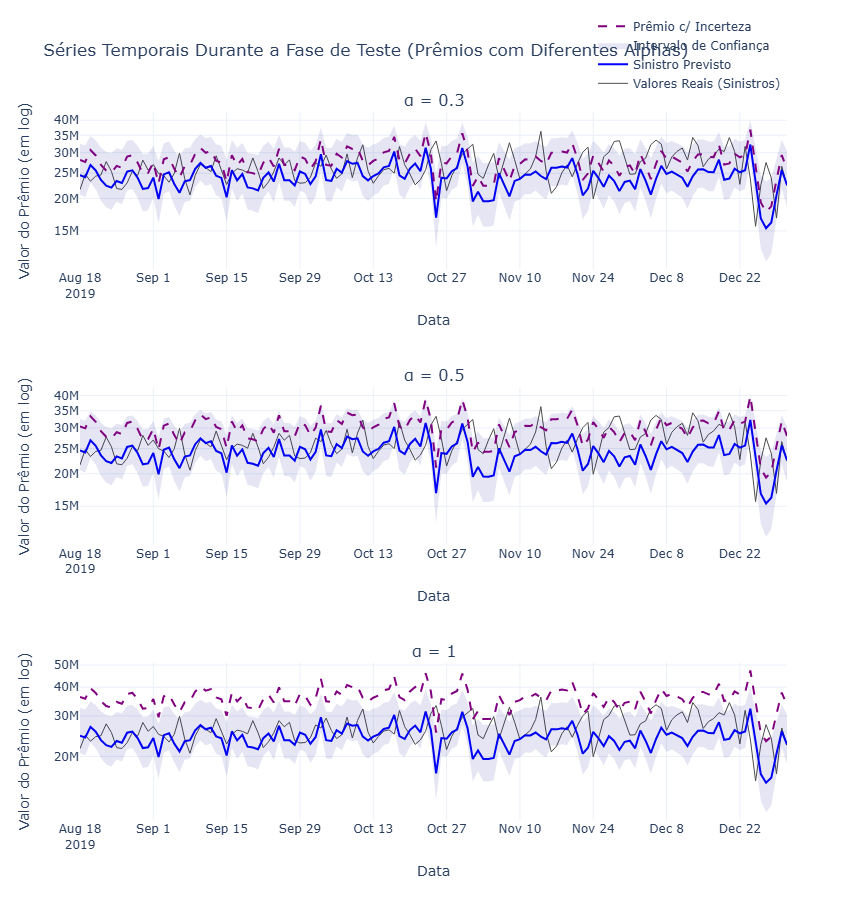

In [37]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

# Define os diferentes valores de alpha
alphas = [0.3, 0.5, 1]

# Cria a figura com subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=[f'α = {alpha}' for alpha in alphas])

# Configurações gerais
fig.update_layout(
    title_text='Séries Temporais Durante a Fase de Teste (Prêmios com Diferentes Alphas)',
    height=900,
    width=1000,
    showlegend=True,
    template='plotly_white'
)

# Gera gráficos para cada valor de alpha
for i, alpha in enumerate(alphas, 1):
    # Calcula o dataframe de prêmios para o valor de alpha atual
    df_premios_alpha = criar_dataframe_premios(test_final_series.time_index, 
                                              pred_test_array, 
                                              upper_quantile, 
                                              lower_quantile, 
                                              alpha=alpha)
    
    # Converte datas para strings (necessário para Plotly)
    dates = [str(date) for date in df_premios_alpha['Data']]
    
    # Valores reais
    fig.add_trace(go.Scatter(
        x=dates,
        y=test_final_series_univariate.values().flatten(),
        name='Valores Reais (Sinistros)',
        line=dict(color='black', width=1),
        opacity=0.7,
        legendgroup=f'group{i}',
        showlegend=True if i==1 else False
    ), row=i, col=1)
    
    # Previsão central
    fig.add_trace(go.Scatter(
        x=dates,
        y=df_premios_alpha['Sinistro Previsto'],
        name='Sinistro Previsto',
        line=dict(color='blue', width=2),
        legendgroup=f'group{i}',
        showlegend=True if i==1 else False
    ), row=i, col=1)
    
    # Intervalo de confiança (área sombreada)
    fig.add_trace(go.Scatter(
        x=dates,
        y=df_premios_alpha['Premio Máximo'],
        fill=None,
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        legendgroup=f'group{i}'
    ), row=i, col=1)
    
    fig.add_trace(go.Scatter(
        x=dates,
        y=df_premios_alpha['Premio Mínimo'],
        fill='tonexty',
        mode='lines',
        line=dict(width=0),
        fillcolor='rgba(0, 0, 139, 0.1)',
        name='Intervalo de Confiança',
        legendgroup=f'group{i}',
        showlegend=True if i==1 else False
    ), row=i, col=1)
    
    # Prêmio com incerteza
    fig.add_trace(go.Scatter(
        x=dates,
        y=df_premios_alpha['Prêmio c/ Incerteza'],
        name='Prêmio c/ Incerteza',
        line=dict(color='purple', width=2, dash='dash'),
        legendgroup=f'group{i}',
        showlegend=True if i==1 else False
    ), row=i, col=1)
    
    # Configurações do eixo Y
    fig.update_yaxes(type="log", row=i, col=1)
    fig.update_xaxes(title_text="Data", row=i, col=1)
    fig.update_yaxes(title_text="Valor do Prêmio (em log)", row=i, col=1)

# Ajusta o layout
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

# Salva como HTML
html_path = os.path.join(paste_graph, "premios_com_diferentes_alphas.html")
fig.write_html(html_path)

# Mostra o gráfico
fig.show()

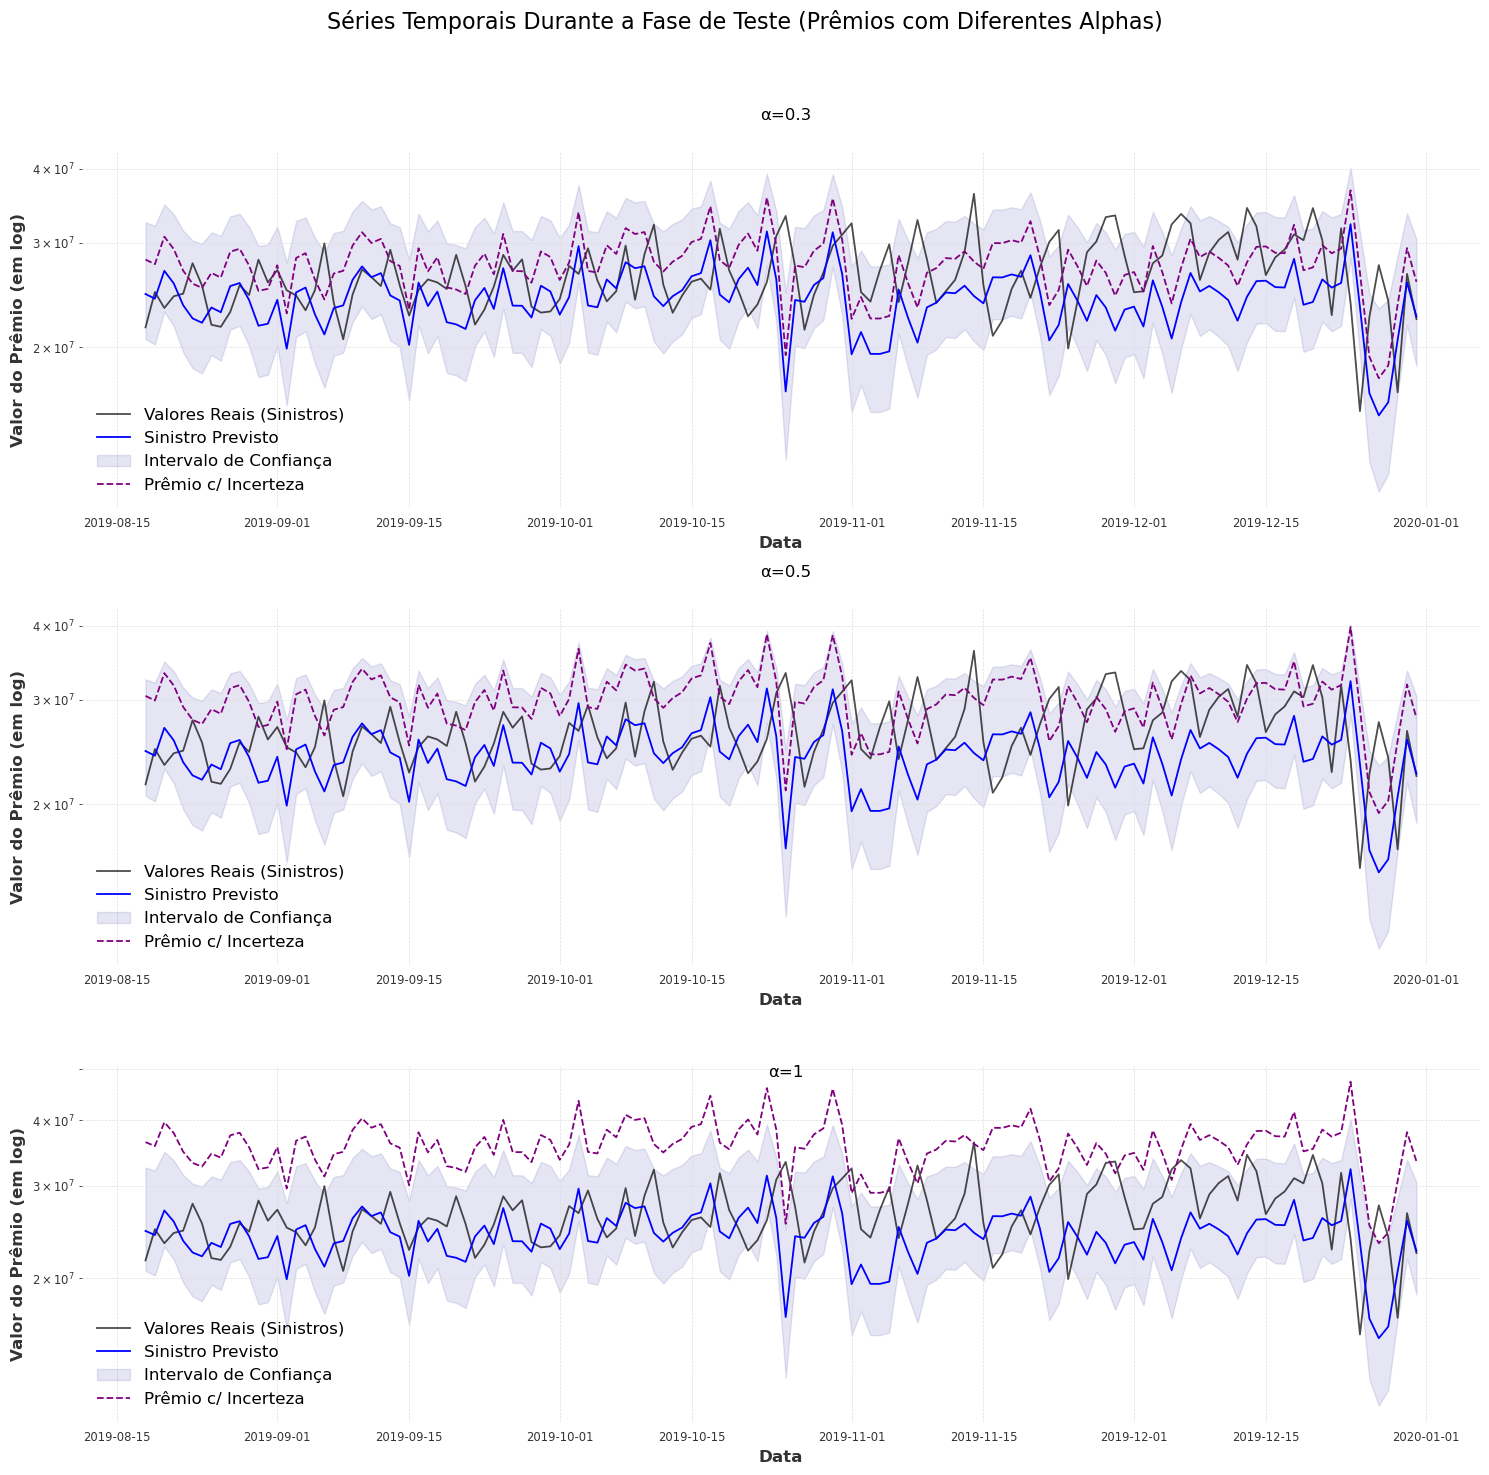

In [38]:
import matplotlib.pyplot as plt

# Define os diferentes valores de alpha
alphas = [0.3, 0.5, 1]

# Cria a figura e os subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

# Título geral
fig.suptitle('Séries Temporais Durante a Fase de Teste (Prêmios com Diferentes Alphas)', fontsize=16)

# Gera gráficos para cada valor de alpha
for i, alpha in enumerate(alphas):

    # Calcula o dataframe de prêmios para o valor de alpha atual
    df_premios_alpha = criar_dataframe_premios(test_final_series.time_index, pred_test_array, upper_quantile, lower_quantile, alpha=alpha)

    # Seleciona o eixo correspondente ao subplot
    ax = axes[i]

    # Plota os valores reais
    ax.plot(test_final_series.time_index, test_final_series_univariate.values().flatten(), label='Valores Reais (Sinistros)', color='black', alpha=0.7)

    # Plota a previsão central
    ax.plot(df_premios_alpha['Data'], df_premios_alpha['Sinistro Previsto'], label='Sinistro Previsto', color='blue')

    # Sombreia a área entre o prêmio máximo e o mínimo
    ax.fill_between(df_premios_alpha['Data'], df_premios_alpha['Premio Mínimo'], df_premios_alpha['Premio Máximo'], color='darkblue', alpha=0.1, label='Intervalo de Confiança')

    # Plotar o prêmio com incerteza
    ax.plot(df_premios_alpha['Data'], df_premios_alpha['Prêmio c/ Incerteza'], label='Prêmio c/ Incerteza', color='purple', linestyle='--')

    # Define título e labels para cada subplot
    # ax.set_title(f'α = {alpha}')
    ax.text(x=test_final_series.time_index[int(len(df_premios_alpha['Data']) / 2)],
         y=max(df_premios_alpha['Sinistro Previsto']) * 1.5,
         s=f"α={alpha}", fontsize=12, color='black', ha='center')
    ax.set_xlabel('Data',fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor do Prêmio (em log)', fontsize=12, fontweight='bold')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(loc='lower left', fontsize=12)

# Ajusta o layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar o layout para deixar espaço para o título geral

# Salva o gráfico
save_path = os.path.join(paste_graph, "premios_com_diferentes_alphas.pdf")
plt.savefig(save_path, facecolor='lightgrey', bbox_inches='tight')

save_path_png = os.path.join(paste_graph, "premios_com_diferentes_alphas.png")
plt.savefig(save_path_png, facecolor='lightgrey', bbox_inches='tight')

# Exibe o gráfico
plt.show()
